<a href="https://colab.research.google.com/github/Tavares2020/Tavares2020/blob/main/04_feature_generation_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FICO Analytic Challenge © Fair Isaac 2025**

# Week 4 - Feature Generation

##Feature Generation Concepts

This week students will continue to learn about feature engineering as a key component of building predictive models for fraud analytics. We will learn to create variables that incorporate the historical activity of a given credit card account holder. Students will gain an appreciation of how a feature may be a good indicator of fraud or non-fraud activity based on how overlapping the respective distributions are. We briefly introduce the concept of correlation.   

In [ ]:
import os
import sys
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/', force_remount=True)

# Base path for your project
path = '/content/drive/MyDrive/FICO Analytic Challenge/'

# Folder that's holding dataset
data = 'Data'

# Model Folder's name
modelFolder='Model'

# Path to the "Data" folder
data_path = os.path.join(path, data)

# Subdirectories to include in sys.path
subdirectories = [data, 'DNU_Functions', modelFolder] + [f'Week_{str(i).zfill(2)}' for i in range(12)]

# Add each subdirectory to sys.path
for subdir in subdirectories:
    sys.path.append(os.path.join(path, subdir))

# Change working directory to the base path
os.chdir(path)
print(os.getcwd())

Mounted at /content/drive/
/content/drive/MyDrive/FICO Analytic Challenge


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from fico_functions import *
from IPython.display import display, Math, Latex, Image

# Plotting library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

# Removing limitation in viewing pandas columns and rows
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [ ]:
# dataset file prefix
trainFile = ['train']
testFile = ['test_A']

# Set to "True" if importing base dataset; default is False
base=True

# Set to "True" if creating advanced features; default is False
creatingAdvancedFeatures=False

# Set to "True" if using advanced features, "False" if using regular features and not base; default is False
usingAdvancedFeatures=False

# CSV filename and where outputs will be saved
trainCSV, trainsaveCSV, _ = featuresFileSuffix(data_path, trainFile, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)
testCSV, testsaveCSV, _ = featuresFileSuffix(data_path, testFile, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)

Only in Week 4
Using train.csv as input. Creating Features and saving all features to train_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/train.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/train_features.csv

Only in Week 4
Using test_A.csv as input. Creating Features and saving all features to test_A_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_A.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_A_features.csv



In [ ]:
#Upload pre-processed data
df1 = import_df(trainCSV)
df2 = import_df(testCSV)

In [ ]:
df1.head()

,pan,merchant,category,transactionAmount,first,last,gender,street,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,mdlIsFraudTrx,mdlIsFraudAcct,transactionDateTime,is_train,merchCountry,merchState,cardholderCountry,cardholderState
179572,T001028354037962B,Zboncak LLC,grocery_pos,1338.57,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,6f65ed65d3f36366420fc82e4f0a499a,1345224472,40.199545,-95.393991,1,1,2020-09-17 15:27:52,1,US,Missouri,US,Missouri
179573,T001028354037962B,Zboncak LLC,shopping_pos,1189.84,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,6f65ed65d3f36366420fc82e4f0a499a,1345224472,40.199545,-95.393991,1,1,2020-09-17 15:41:52,1,US,Missouri,US,Missouri
179574,T001028354037962B,Zboncak LLC,misc_pos,743.65,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,6f65ed65d3f36366420fc82e4f0a499a,1345224472,40.199545,-95.393991,1,1,2020-09-17 15:55:52,1,US,Missouri,US,Missouri
179575,T001028354037962B,Zboncak LLC,grocery_pos,1338.57,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,6f65ed65d3f36366420fc82e4f0a499a,1345224472,40.199545,-95.393991,1,1,2020-09-17 16:09:52,1,US,Missouri,US,Missouri
179576,T001028354037962B,Zboncak LLC,food_dining,1189.84,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,6f65ed65d3f36366420fc82e4f0a499a,1345224472,40.199545,-95.393991,1,1,2020-09-17 16:23:52,1,US,Missouri,US,Missouri


In [ ]:
df2.head()

,pan,merchant,category,transactionAmount,first,last,gender,street,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,mdlIsFraudTrx,mdlIsFraudAcct,transactionDateTime,is_train,merchCountry,merchState,cardholderCountry,cardholderState
122235,A001028354037962B,"Bins, Balistreri and Beatty",shopping_pos,3.19,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,20c1cf41b472000887395508c5796354,1325386894,39.299707,-95.975808,0,1,2020-02-01 00:01:34,0,US,Kansas,US,Missouri
122236,A001028354037962B,Terry-Huel,shopping_net,9.52,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,771a63aaf5210acfbf5ac2403aad30af,1325390918,39.790646,-95.043146,0,1,2020-02-01 00:08:38,0,US,Kansas,US,Missouri
122237,A001028354037962B,Johnston-Casper,travel,7.33,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,7a30020f6af806a03b3e3b859b9a2df4,1325424070,40.977943,-96.135389,0,1,2020-02-01 00:21:10,0,US,Nebraska,US,Missouri
122238,A001028354037962B,Prohaska-Murray,gas_transport,46.66,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,b8e3100c6bccb605dd98a848e2c76eda,1325396176,41.071606,-94.999602,0,1,2020-02-01 00:36:16,0,US,Iowa,US,Missouri
122239,A001028354037962B,Hudson-Ratke,grocery_pos,84.04,Melody,Thompson,F,0362 Anderson Wall,64470,40.1362,-95.2138,1631,Architect,1953-01-20,a4124a63fe29428a307eb671a3f03ba3,1325407994,40.638122,-95.834340,0,1,2020-02-01 00:53:14,0,US,Nebraska,US,Missouri


In [ ]:
df1.columns

Index(['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last',
       'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry',
       'merchState', 'cardholderCountry', 'cardholderState'],
      dtype='object')

In [ ]:
df2.columns

Index(['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last',
       'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry',
       'merchState', 'cardholderCountry', 'cardholderState'],
      dtype='object')

In [ ]:
#Combine dataframes to be processed together
df = pd.concat([df1,df2], ignore_index=True, axis=0)

In [ ]:
# Ensure base_cols is a list of strings
base_cols = list(map(str, df.columns))

In [ ]:
base_cols

['pan',
 'merchant',
 'category',
 'transactionAmount',
 'first',
 'last',
 'gender',
 'street',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'mdlIsFraudTrx',
 'mdlIsFraudAcct',
 'transactionDateTime',
 'is_train',
 'merchCountry',
 'merchState',
 'cardholderCountry',
 'cardholderState']

In [ ]:
#It often helps to decompose the datetime into more useful fields
df['datetime'] =  pd.to_datetime(df['transactionDateTime'])
df['transactionHour'] = df['datetime'].dt.hour

#Since many of our features will be calculated at the account level, let's sort our features accordingly
df.sort_values(by=['pan','transactionDateTime'], inplace=True)

#When reordering data, it's customary to reset the index to align with the order of the rows
df.reset_index(drop=True, inplace=True)

# Handling Non-Numeric Values

- In transaction data, many features are categorical, such as the type of transaction (cash, online purchase, etc.), the country of the merchant, or the type of merchant itself. <font
color
='red'>Machine learning algorithms require numerical input</font>, so we need to convert these categorical features into numerical values. A common method to achieve this is Label Encoding.

- **Label Encoding** is useful when the categorical variable has only two possible values. It assigns 0 and 1 to the two categories. You have seen this, for example, in the binary variables we defined in week 3. Some examples of these are is_cnp and IS_0_TO_5AM

## Let's again take a look at what fields we have available to generate our features from

In [ ]:
df.columns

Index(['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last',
       'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry',
       'merchState', 'cardholderCountry', 'cardholderState', 'datetime',
       'transactionHour'],
      dtype='object')

Using variables such as name, gender, or even city in a neural network model can lead to ethical violations primarily due to privacy concerns and potential biases. Personal identifiers like 'first' and 'last' names can compromise the anonymity of individuals, leading to privacy breaches. Variables like 'gender', 'city', 'state', and 'zip' can introduce biases, as they may be correlated with sensitive demographic information, potentially resulting in unfair or discriminatory outcomes. For instance, gender bias might lead to unequal treatment or opportunities based on sex. Geographical data such as 'street', 'city', 'state', and 'zip' codes can also perpetuate socio-economic biases and contribute to systemic inequalities. Additionally, using 'job' and 'dob' (date of birth) can further exacerbate age and employment discrimination. Therefore, it is crucial to carefully consider the ethical implications and ensure proper data anonymization and fairness in model training.

## We can define some more binary features based on these which may or may not be indicative of fraud

In [ ]:
#Calculate some basic binary variables

#Fraudsters want to get as much money as fast as possible. Having a high value variable might catch some of the more greedy criminals
df['IsHighValue'] = (df['transactionAmount'] > 100.).astype(int)

#Transactions occurring in a country different from the customer's home country can indicate potential fraud, especially if the customer rarely travels.
df['is_international'] = (df['merchCountry'] != df['cardholderCountry']).astype(int)

#Fraud is most easily committed anonymously and discreetly; by conducting the crime over the internet, the chances of being caught are much lower.
df['is_CNP'] =  (df['category'].apply(lambda x: x[-3:] == 'net')).astype(int)

#Similarly, security and awareness are at their lowest at off hours. Fraudsters frequently exploit this weakness.
df['IS_0_TO_5AM'] = (df['transactionHour'].astype(int) < 5).astype(int)

In [ ]:
# Ensure df.columns is a list of strings
df_columns = list(map(str, df.columns))

if "datetime" in df.columns:
  binary_vars = list(set(df_columns) - set(base_cols + ['transactionHour', 'datetime']))
else:
  binary_vars = list(set(df_columns) - set(base_cols + ['transactionHour']))

binary_vars.sort()
print(binary_vars)

['IS_0_TO_5AM', 'IsHighValue', 'is_CNP', 'is_international']


## Check the fraud rate for each of these variables for 0 and 1 values

In [ ]:
#We can loop over our features and compare the fraud rate for when each of these conditions are met
for var in binary_vars:
    is_condition = df[df[var] == 1]['mdlIsFraudAcct'].value_counts(normalize=True)
    not_condition = df[df[var] == 0]['mdlIsFraudAcct'].value_counts(normalize=True)
    print(f'{var} has proportionally',(is_condition[1]/not_condition[1]-1)*100, '% more fraud')

IS_0_TO_5AM has proportionally 34.52471489656017 % more fraud
IsHighValue has proportionally -8.104025662025293 % more fraud
is_CNP has proportionally 0.9734923731727019 % more fraud
is_international has proportionally 66.21074775853376 % more fraud


In [ ]:
#Let's try and be more in-line with the data as was seen in week 3:
df['is_late_night'] = ((df['transactionHour'].astype(int) < 4) | (df['transactionHour'].astype(int) > 21)).astype(int)

In [ ]:
# Ensure df.columns is a list of strings
df_columns = list(map(str, df.columns))

if "datetime" in df.columns:
  binary_vars = list(set(df_columns) - set(base_cols + ['transactionHour', 'datetime']))
else:
  binary_vars = list(set(df_columns) - set(base_cols + ['transactionHour']))

binary_vars.sort()
print(binary_vars)

['IS_0_TO_5AM', 'IsHighValue', 'is_CNP', 'is_international', 'is_late_night']


In [ ]:
#We can again loop over our features and compare the fraud rate for when each of these conditions are met
for var in binary_vars:
    is_condition = df[df[var] == 1]['mdlIsFraudAcct'].value_counts(normalize=True)
    not_condition = df[df[var] == 0]['mdlIsFraudAcct'].value_counts(normalize=True)
    print(f'{var} has proportionally',(is_condition[1]/not_condition[1]-1)*100, '% more fraud')

IS_0_TO_5AM has proportionally 34.52471489656017 % more fraud
IsHighValue has proportionally -8.104025662025293 % more fraud
is_CNP has proportionally 0.9734923731727019 % more fraud
is_international has proportionally 66.21074775853376 % more fraud
is_late_night has proportionally 39.21607963158817 % more fraud


### From this, we can see that all of these besides is_cnp might be good variables to use in our feature selections! We also may note that IS_0_TO_5AM and is_late_night variables both perform well, but since they contain very similar information, their correlation may lead to overemphasis on this information.

## Going beyond Label Encoding, we can start defining customer-specific features

###An important consideration for feature engineering is causality. I.e. we must restrict ourselves to only the past and present when calculating a feature for the current transaction. For instance, instead of taking the mean of our entire dataset, we are only allowed to take the mean of all transactions occurring prior to our current transaction. This is achieved using either the `expanding` or `rolling` functions.

In [ ]:
# PAN behavior anomalies
#For this next line: the combination of expanding() and shift() take only the data prior to our current transaction
df['user_avg_amount'] = df.groupby('pan', group_keys=False)['transactionAmount'].transform(lambda x: x.expanding().mean().shift())
df['user_avg_amount'] = df['user_avg_amount'].fillna(df['transactionAmount'])
# df['user_avg_amount'] = df['user_avg_amount'].fillna(0)

##Let's break this down piece-by-piece
**df.groupby('pan'):** Groups the DataFrame by the 'pan' column. Each unique pan will form a separate group.

**['transactionAmount']**:
Selects the 'transactionAmount' column within each group for further operations.

**.expanding()**: Creates an expanding window, starting from the first transaction and expanding to include all transactions up to the current one for each pan.

**.mean()**: Calculates the mean of all transactions seen so far within the expanding window for each group.

**.shift()**: Shifts the result by one row for each customer, meaning the current row will have the mean of all prior transactions (not including the current one).

**.reset_index(level=0, drop=True)** Resets the index after the groupby operation, removing the 'pan' as an index and flattening the DataFrame. 'drop=True' ensures the 'pan' is not added back as a column.

In [ ]:
#By comparing a user's current transaction to their normal spending activity, we may detect user-specific anomalies
df['RelativeAmount'] = df['transactionAmount'] / df['user_avg_amount']
# df['RelativeAmount'].replace([np.inf, -np.inf], 0, inplace=True)

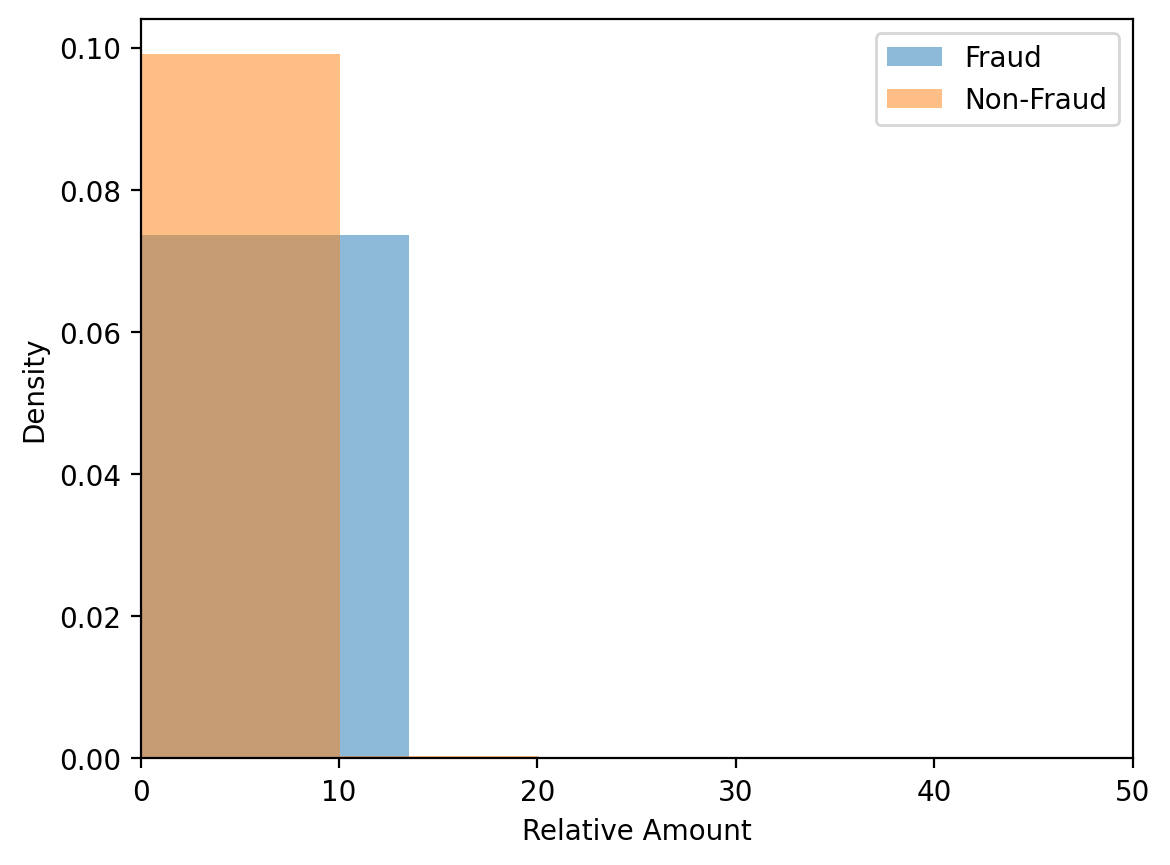

In [ ]:
# Plot histograms
plt.hist(df[(df['mdlIsFraudAcct'] == 1) & (df['RelativeAmount'] > 0.)]['RelativeAmount'], bins=50, density=True, alpha=0.5, label='Fraud')
plt.hist(df[(df['mdlIsFraudAcct'] == 0) & (df['RelativeAmount'] > 0.)]['RelativeAmount'], bins=50, density=True, alpha=0.5, label='Non-Fraud')

# Add labels and legend
plt.xlabel('Relative Amount')
plt.ylabel('Density')
plt.xlim([0,50])
#plt.title('Normalized Histograms')
plt.legend()

# Show plot
plt.show()

## From this plot, it seems the two distributions are somewhat overlapping, but there is a sharp drop after RelativeAmount > 10. This might make a good binary variable. Think about how you might implement this into your model. For now, let's explore other options.

# Generating New Variables

- Creating new features from existing data can help uncover patterns and improve the performance of machine learning models. Read more on the process of feature engineering in the following links: https://builtin.com/articles/feature-engineering up to "Best Feature Engineering Tools to Know section." https://www.featureform.com/post/feature-engineering-guide up to "The Lifecycle of a Machine Learning Project section." Here, we will generate new features that provide additional insights into the transaction behavior:



# Let's pause to reflect on our initial fields and the new features we've created

In [ ]:
df.keys()

Index(['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last',
       'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry',
       'merchState', 'cardholderCountry', 'cardholderState', 'datetime',
       'transactionHour', 'IsHighValue', 'is_international', 'is_CNP',
       'IS_0_TO_5AM', 'is_late_night', 'user_avg_amount', 'RelativeAmount'],
      dtype='object')

Though we are limited with our available fields, there are still ways to squeeze useful features from an ostensibly incomplete dataset. Sometimes signal can be lost in the noise of non-fraud fluctuations. A good way to suppress this noise is by implementing a rolling windows average. In the example below, we see a very noise curve (blue), but with a rolling average, we can more easily ascertain the true nature of the pattern: a simple sin curve (red).
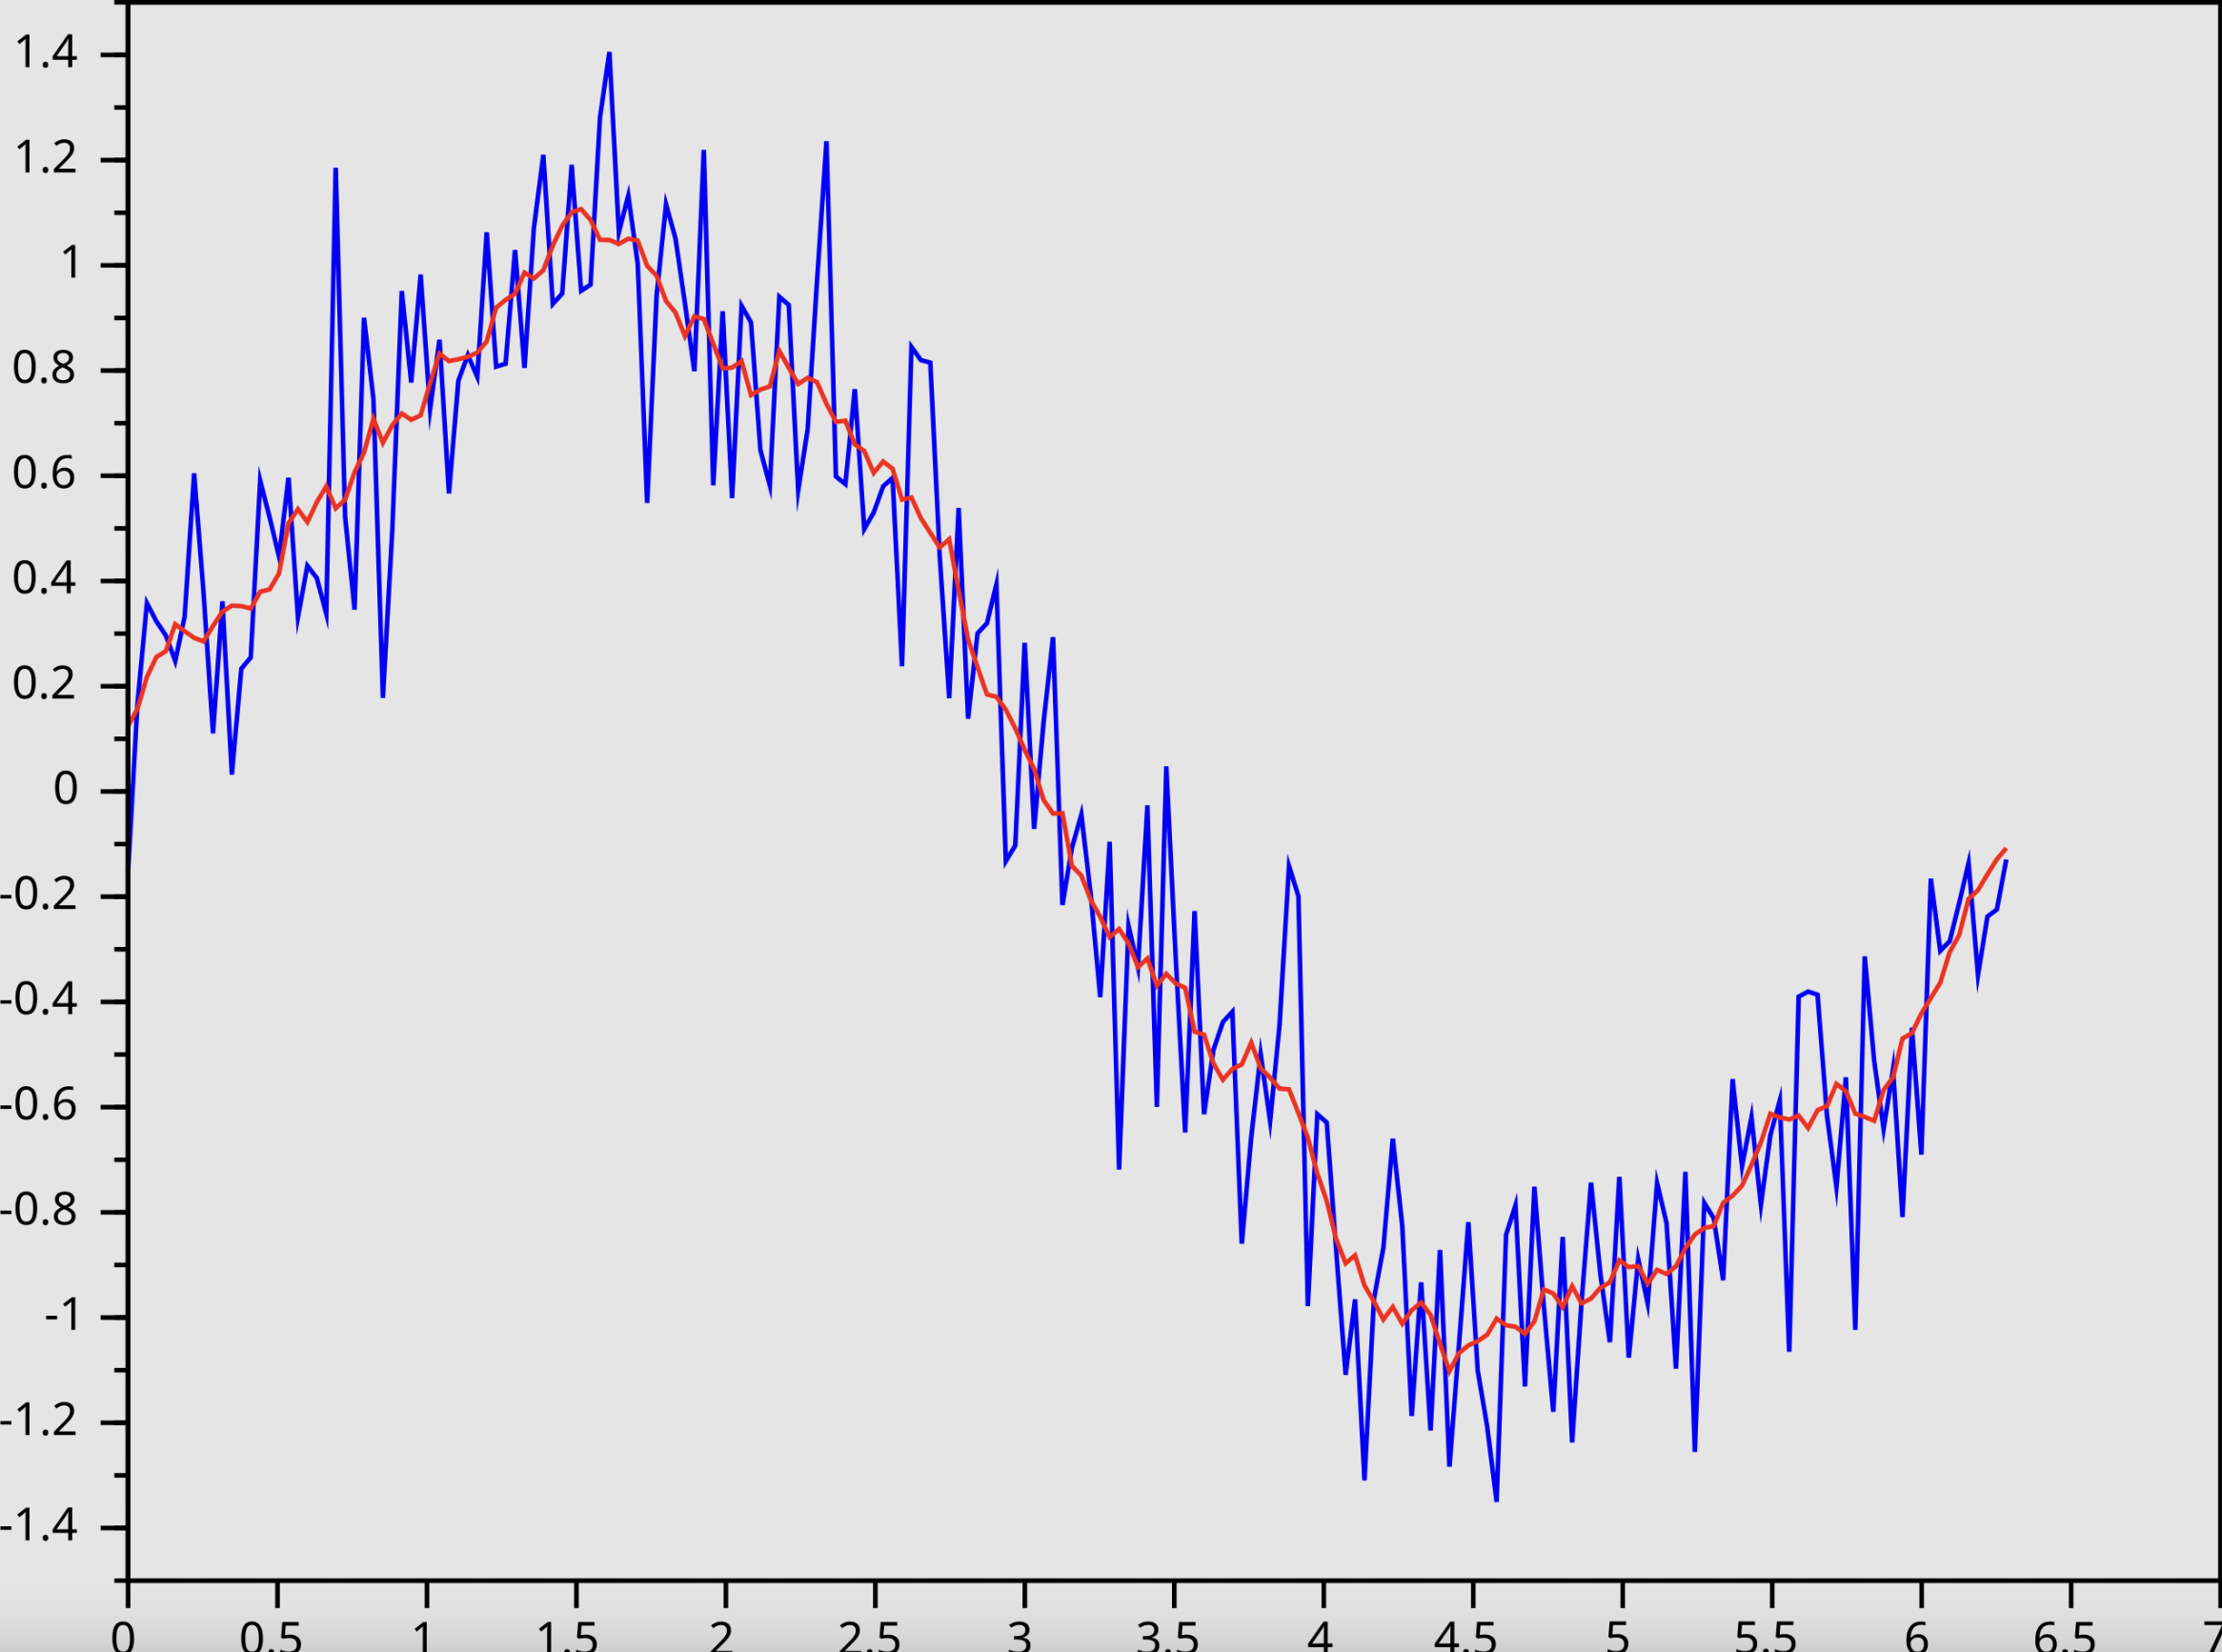

In [ ]:
if 'datetime' not in df.columns:
  df['datetime'] =  pd.to_datetime(df['transactionDateTime'])
  df = df.sort_values(by=['pan', 'transactionDateTime'])
  df.reset_index(drop=True, inplace=True)

# Very short intervals between transactions can be suspicious, especially if they are unusual for the customer.
df['deltaTime'] = df.groupby('pan')['datetime'].transform(lambda x: x.diff().dt.total_seconds()) # Time in seconds between the current and last transactions

# Replace NaNs with 0
df['deltaTime'] = df['deltaTime'].fillna(0)

# This rolling average helps to understand the trend in transaction amounts. Sudden changes in trend might be indicative of fraud.
df['amt_trend_5e'] = df.groupby('pan')['transactionAmount'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

In [ ]:
df.columns

Index(['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last',
       'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob',
       'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx',
       'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry',
       'merchState', 'cardholderCountry', 'cardholderState', 'datetime',
       'transactionHour', 'IsHighValue', 'is_international', 'is_CNP',
       'IS_0_TO_5AM', 'is_late_night', 'user_avg_amount', 'RelativeAmount',
       'deltaTime', 'amt_trend_5e'],
      dtype='object')

In [ ]:
if 'datetime' not in df.columns:
  df['datetime'] =  pd.to_datetime(df['transactionDateTime'])
  df = df.sort_values(by=['pan', 'transactionDateTime'])
  df.reset_index(drop=True, inplace=True)

# Instead of taking the trend over a number of events, we can also specify a period over which we're interested
df.set_index('datetime', inplace=True)

# Looking at the average of the last day's transactions may reveal a large average transaction trend
df['amt_trend_24h'] = df.groupby('pan')['transactionAmount'].transform(lambda x: x.rolling(window='24h').mean())

# Looking at the number volume of transactions can often also be an indicator of
# fraud. The perpetrators want to commit as muhc fraud as fast as possible
df['count_trend_1h'] = df.groupby('pan')['transactionAmount'].transform(lambda x: x.rolling(window='1h').count())

In [ ]:
df.reset_index(drop=True, inplace=True)
df['datetime'] =  pd.to_datetime(df['transactionDateTime'])

# Often times, fraudsters will purchase or withdraw the same item or amount in succession
df['repeat_amt'] = (df['transactionAmount'] == df.groupby('pan')['transactionAmount'].shift(1)).astype(int)

The t-statistic (or t-stat) is a value derived from a statistical hypothesis test. It is used to determine if there is a significant difference between the means of two groups, or to test other statistical hypotheses about the parameters of a population. The t-statistic is calculated using the sample data and compares the sample mean to the population mean, adjusted for the sample size and variability.



Feature: IS_0_TO_5AM, t-statistic: 86.5776979440063, p-value: 0.0


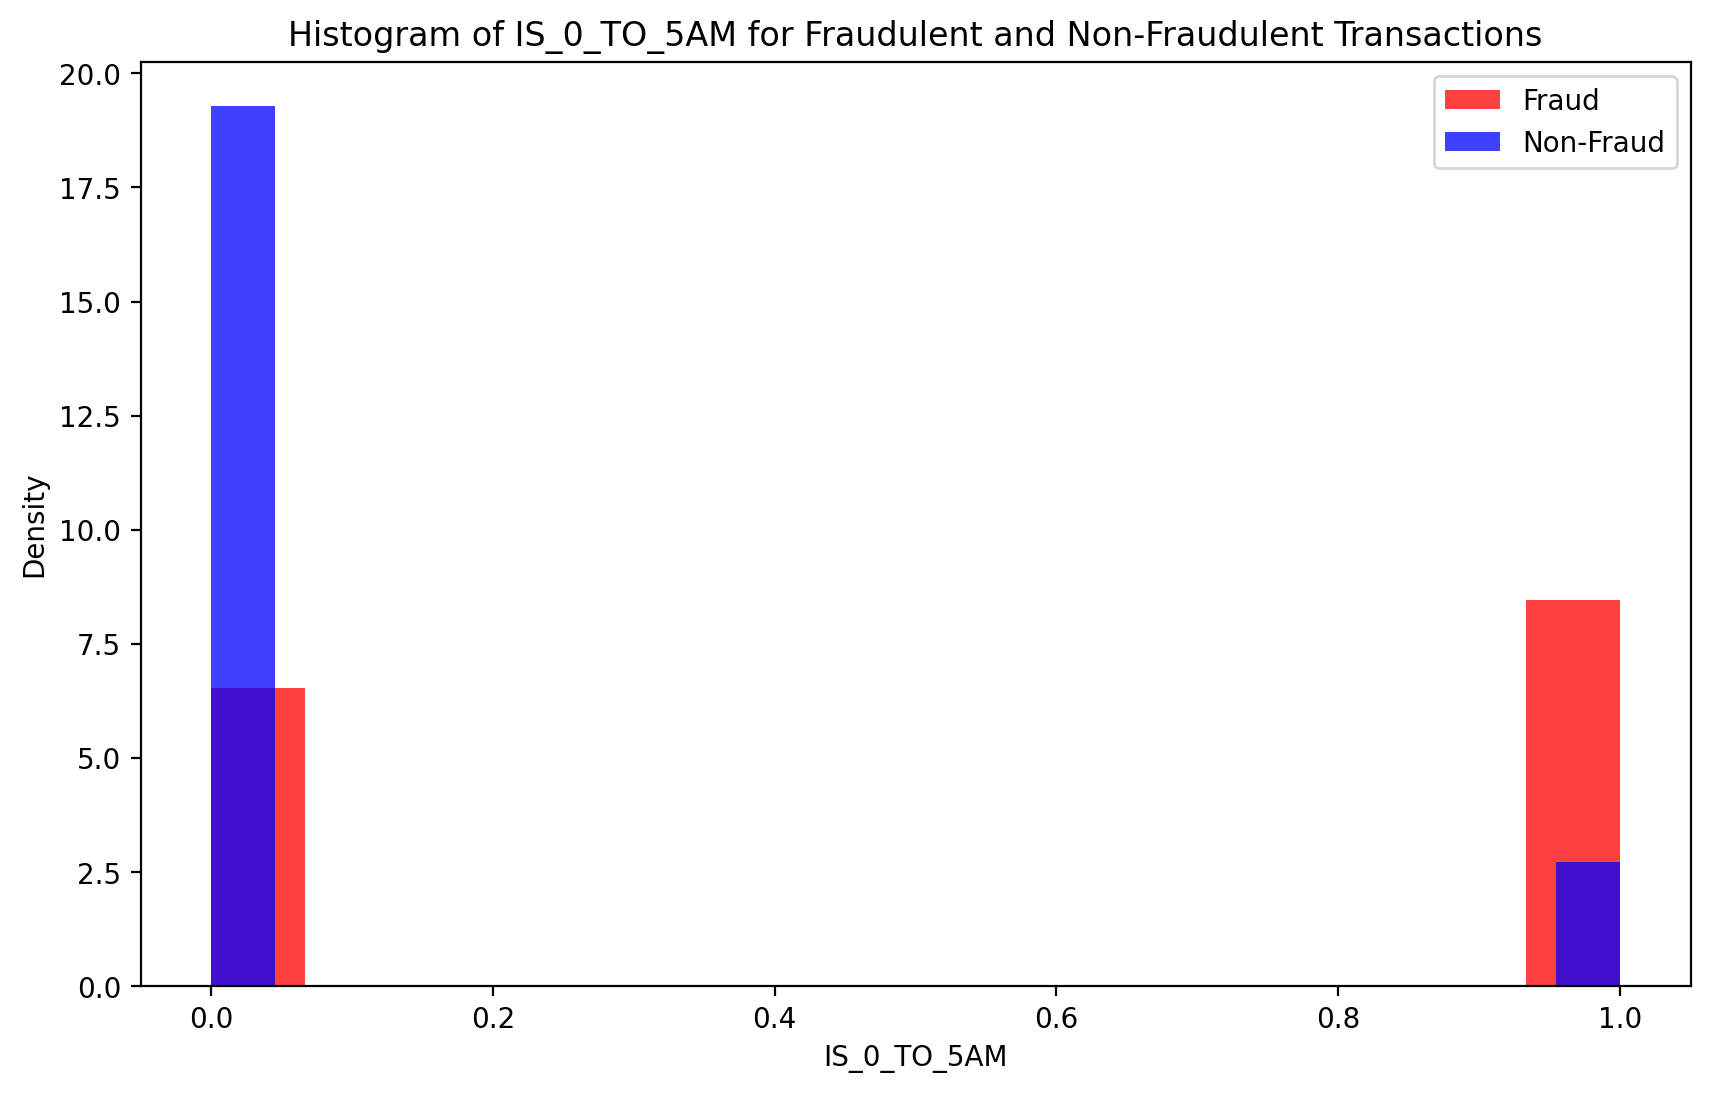

Feature: repeat_amt, t-statistic: 29.422613435343713, p-value: 3.537383243748704e-182


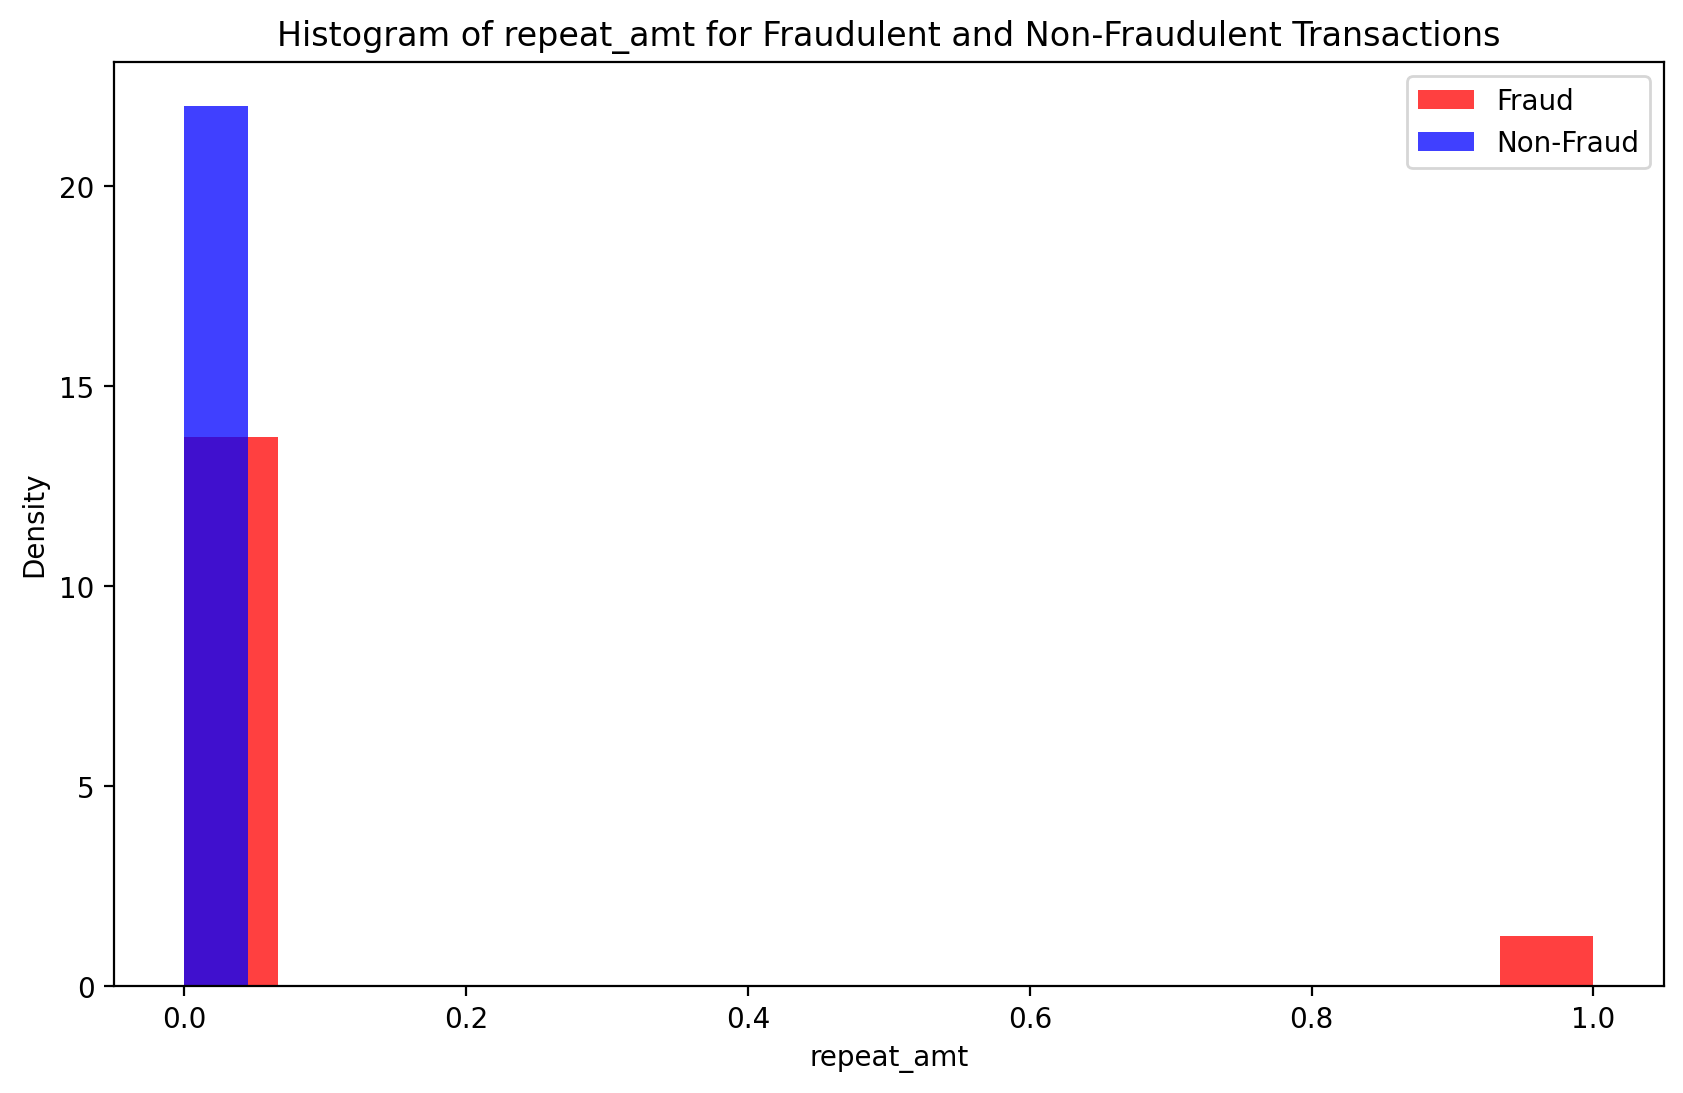

Feature: is_international, t-statistic: 9.317166012135834, p-value: 1.45952200864168e-20


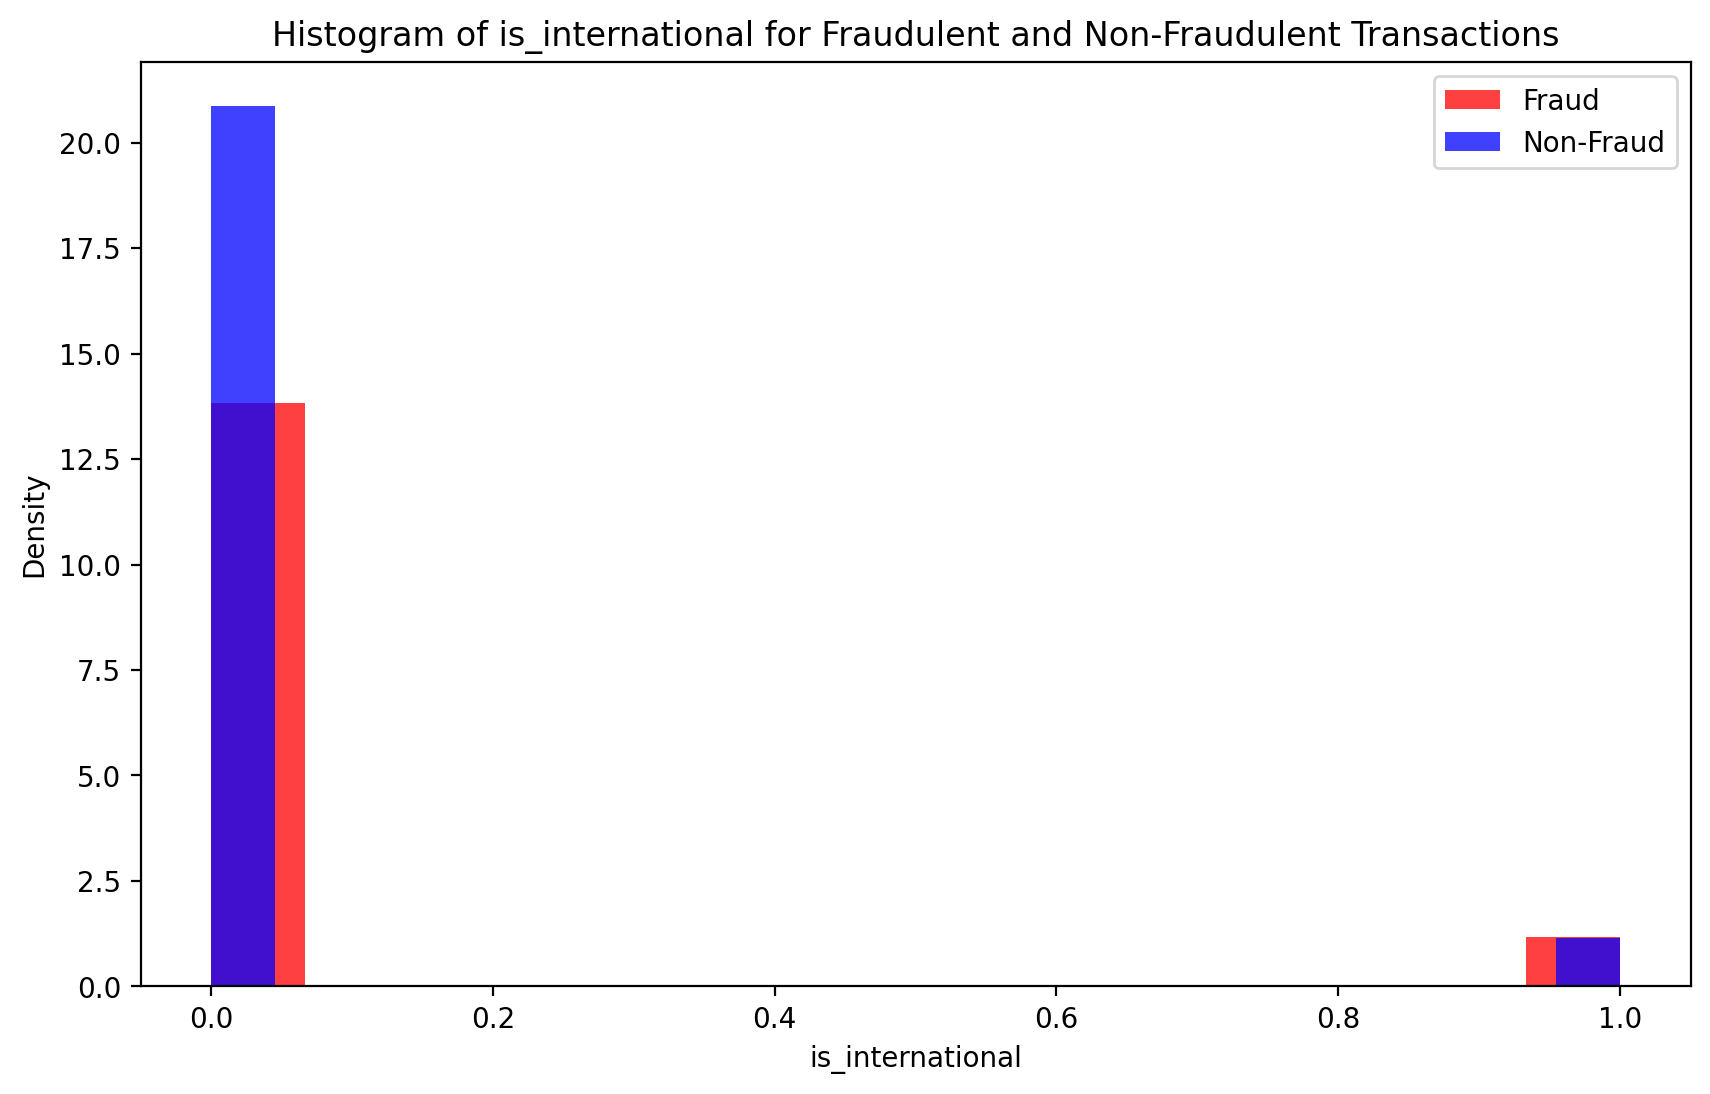

Feature: transactionHour, t-statistic: -58.530772573562636, p-value: 0.0


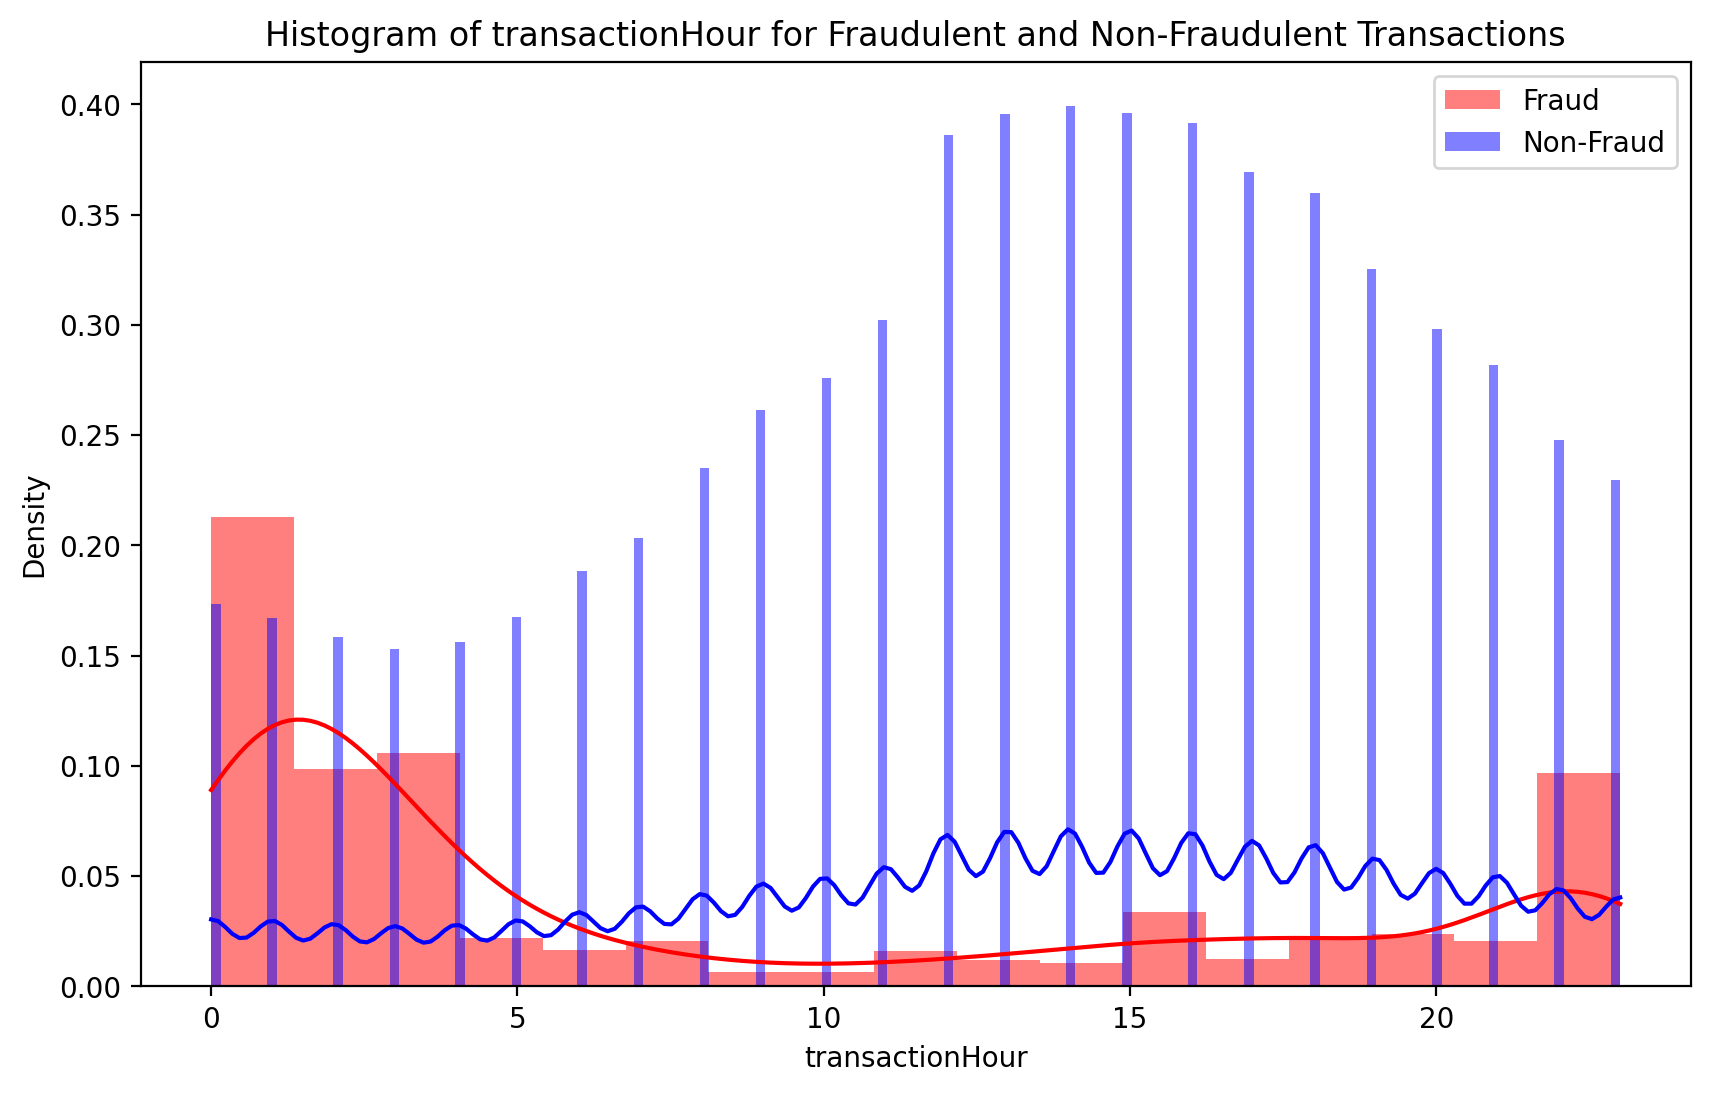

Feature: is_CNP, t-statistic: 40.31188170149836, p-value: 0.0


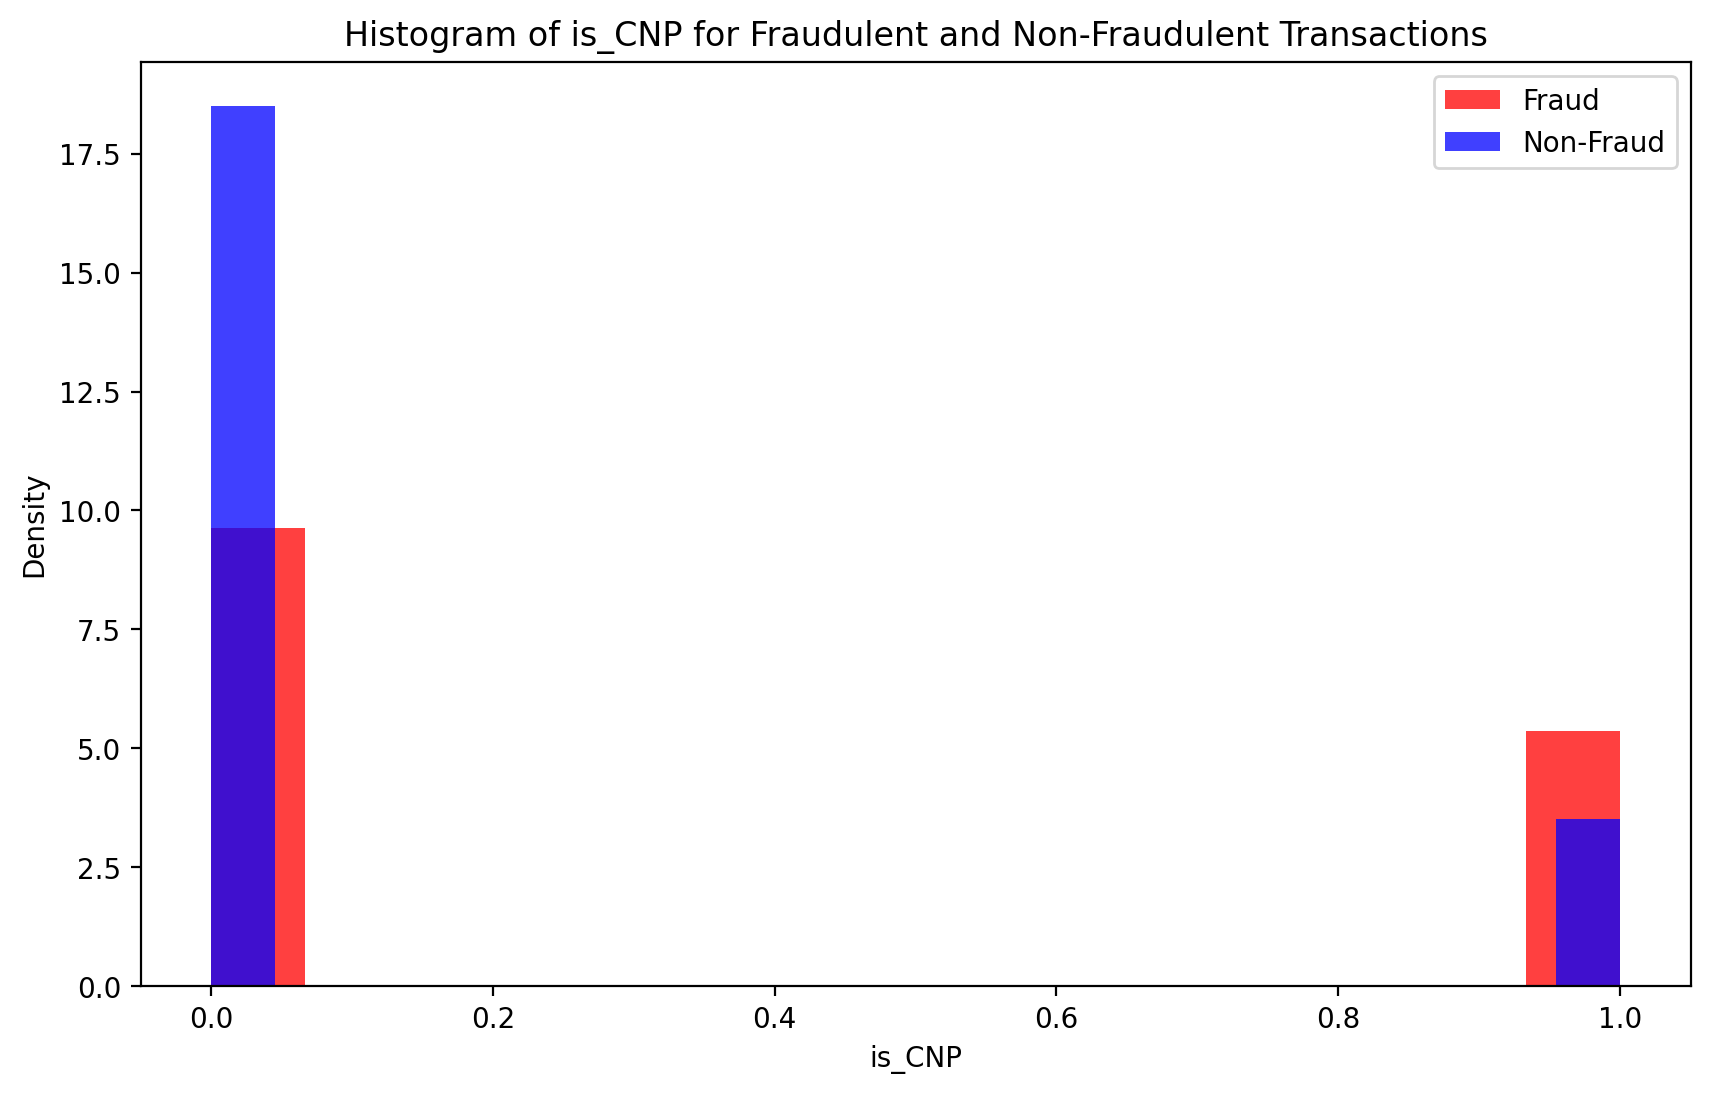

Feature: IsHighValue, t-statistic: 122.11560840404002, p-value: 0.0


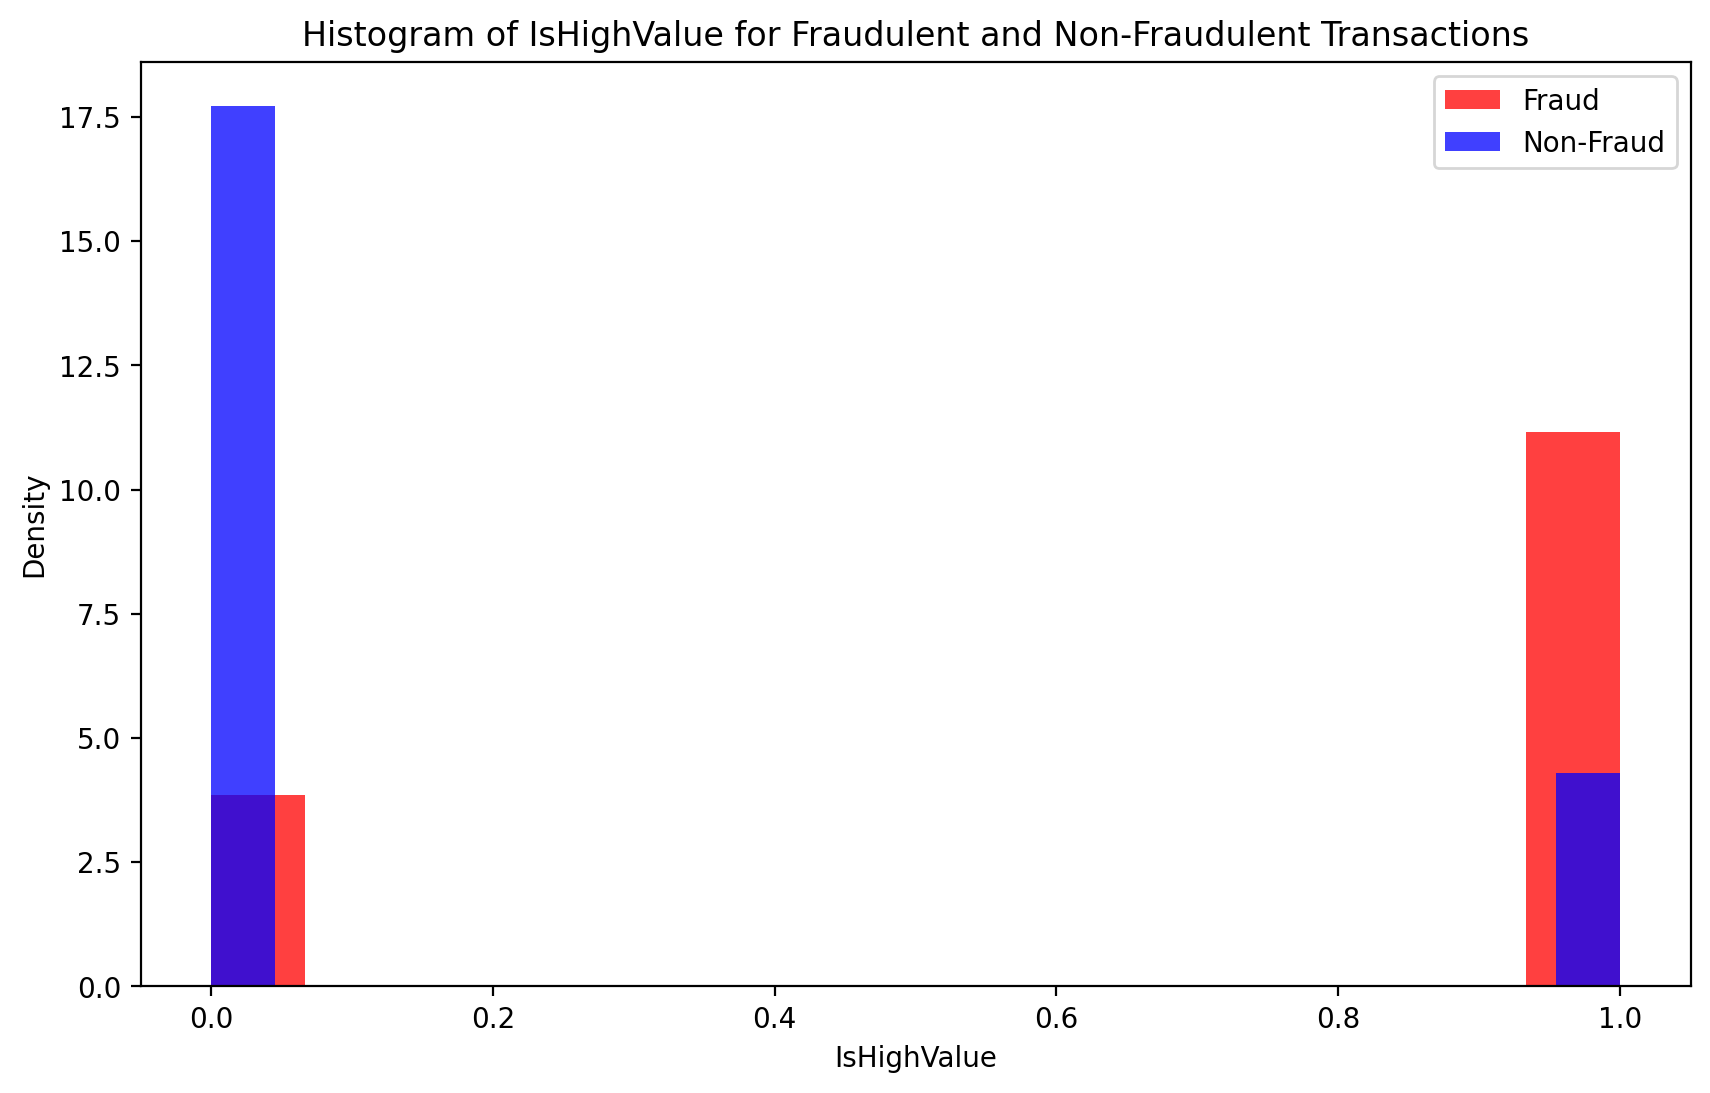

Feature: deltaTime, t-statistic: -40.229199410678106, p-value: 0.0


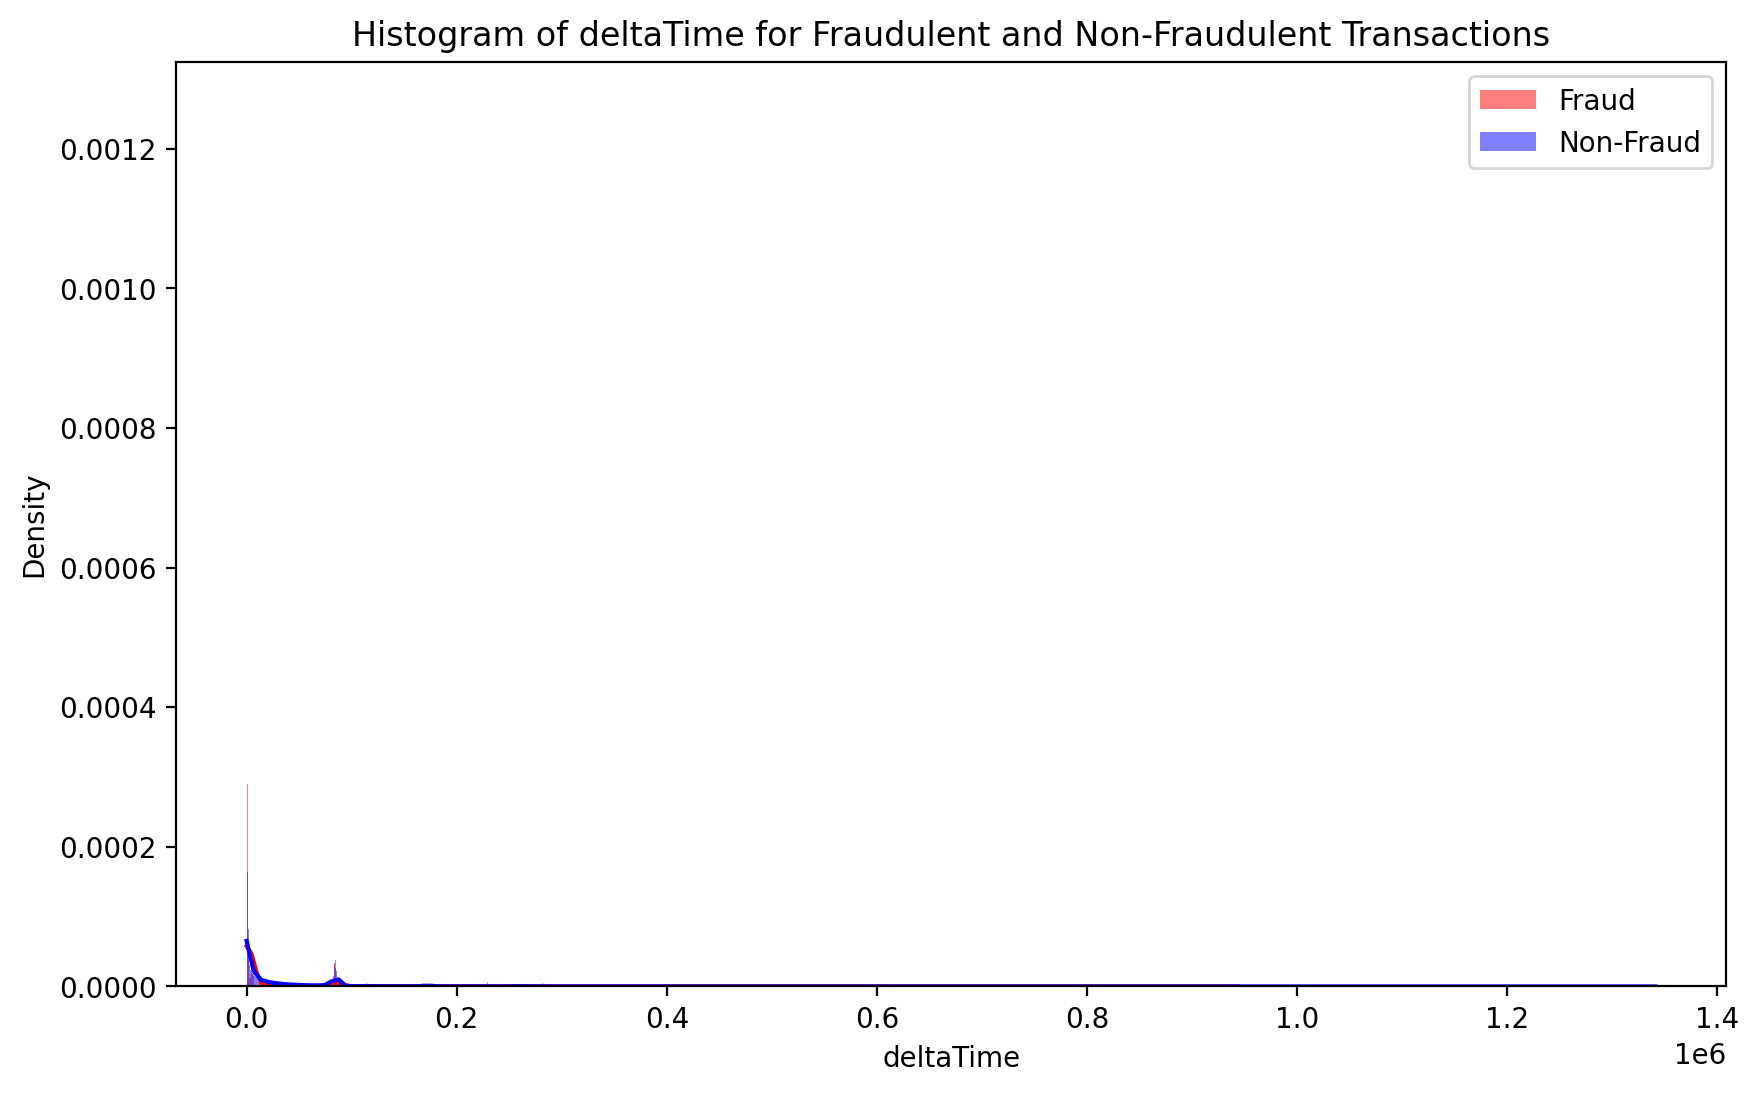

Feature: amt_trend_24h, t-statistic: 130.00595689859858, p-value: 0.0


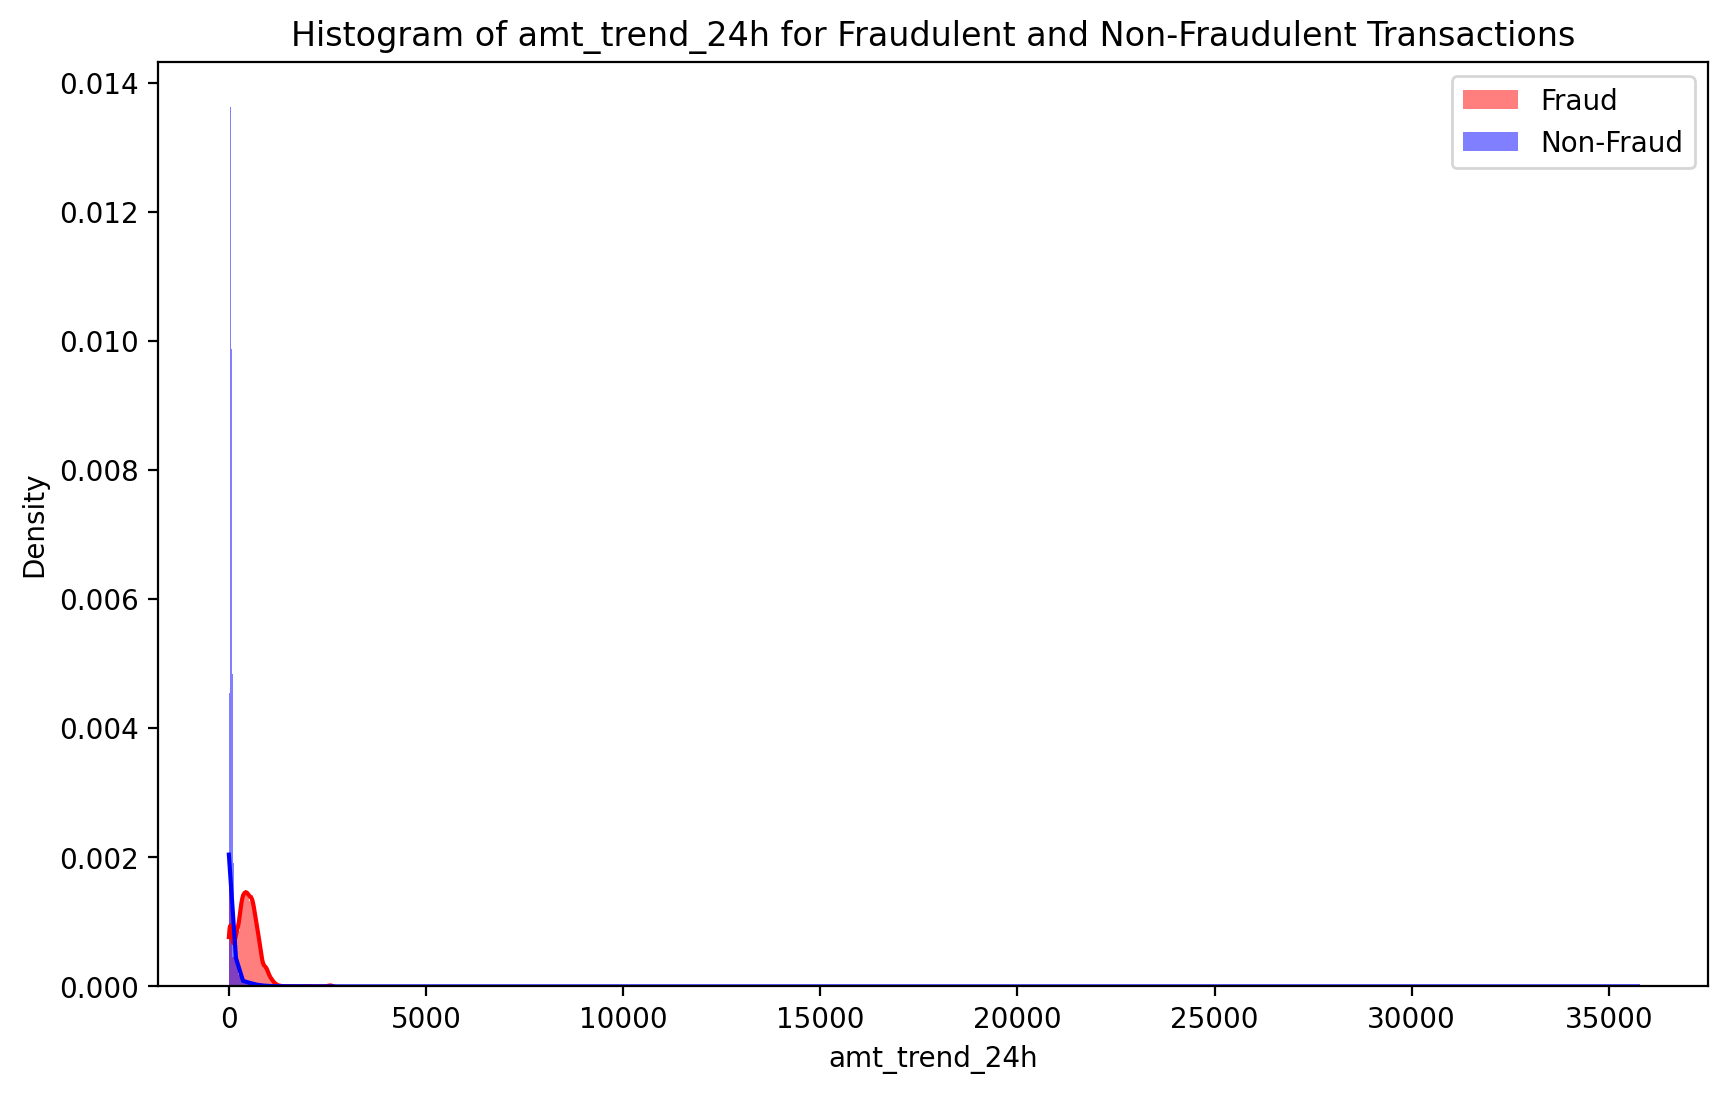

Feature: amt_trend_5e, t-statistic: 124.34688593882242, p-value: 0.0


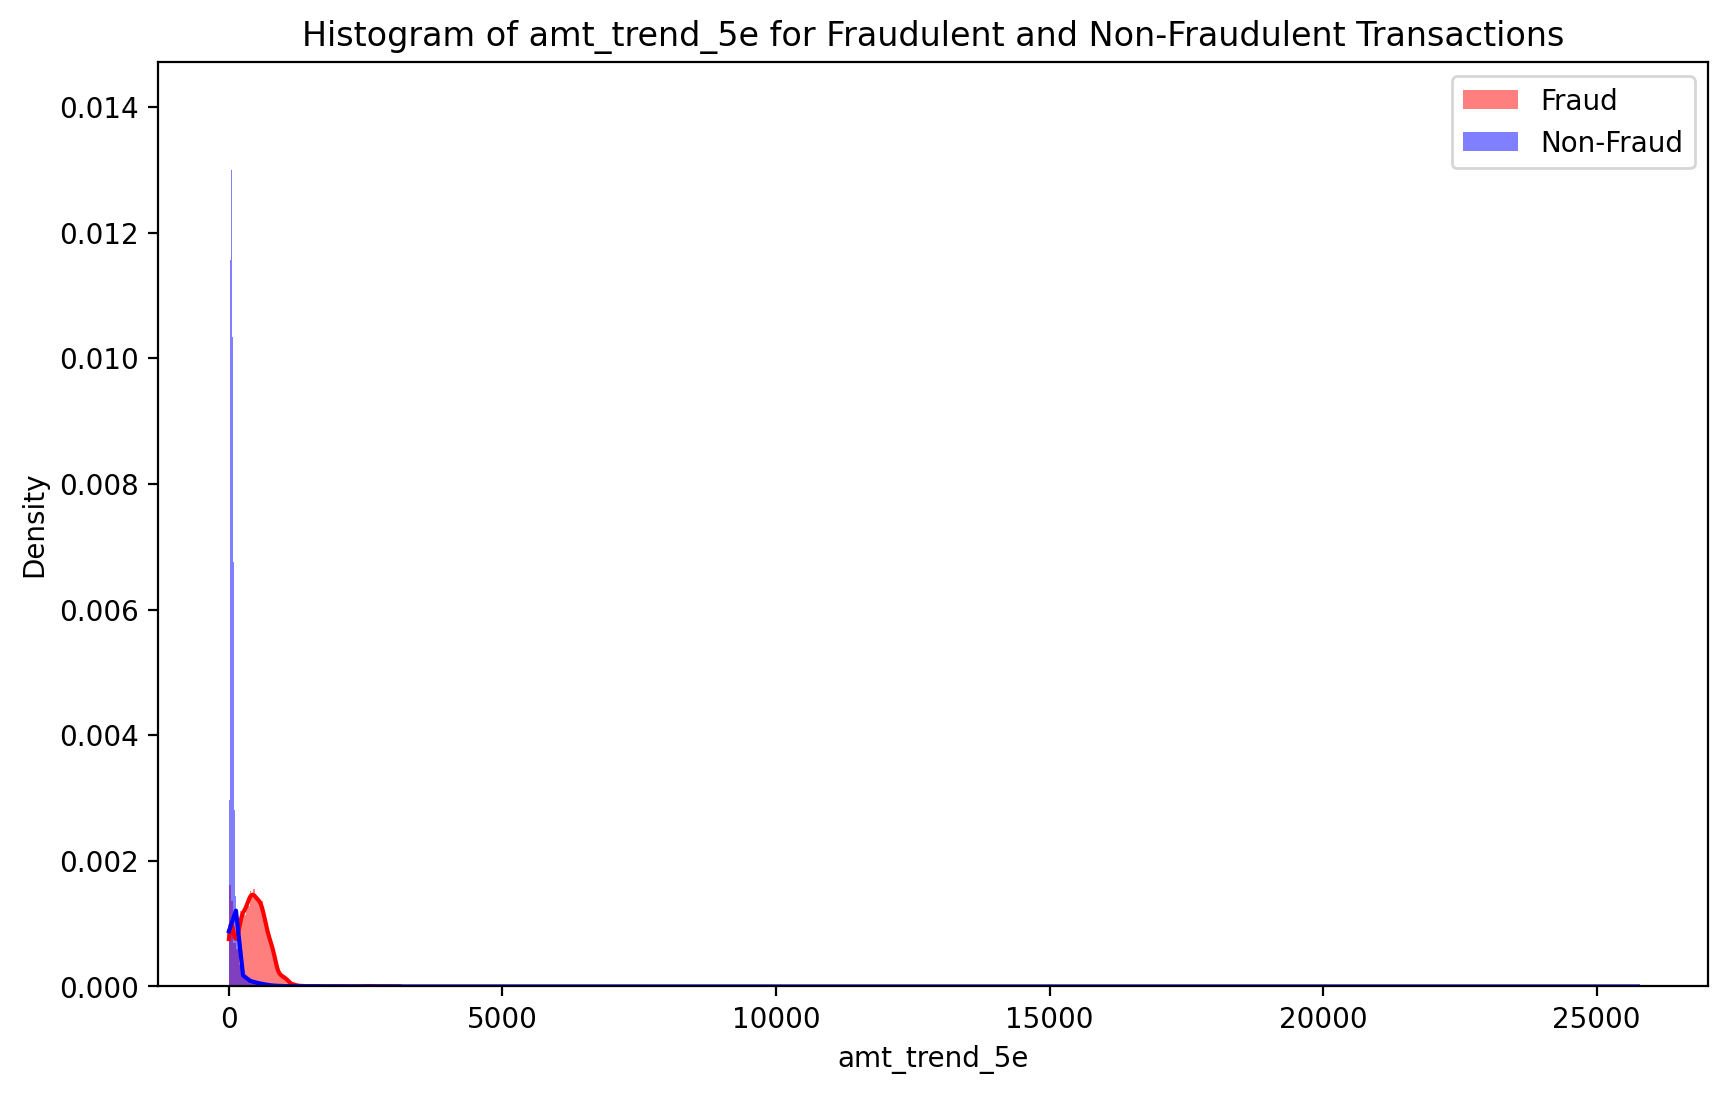

Feature: RelativeAmount, t-statistic: 76.12139415568703, p-value: 0.0


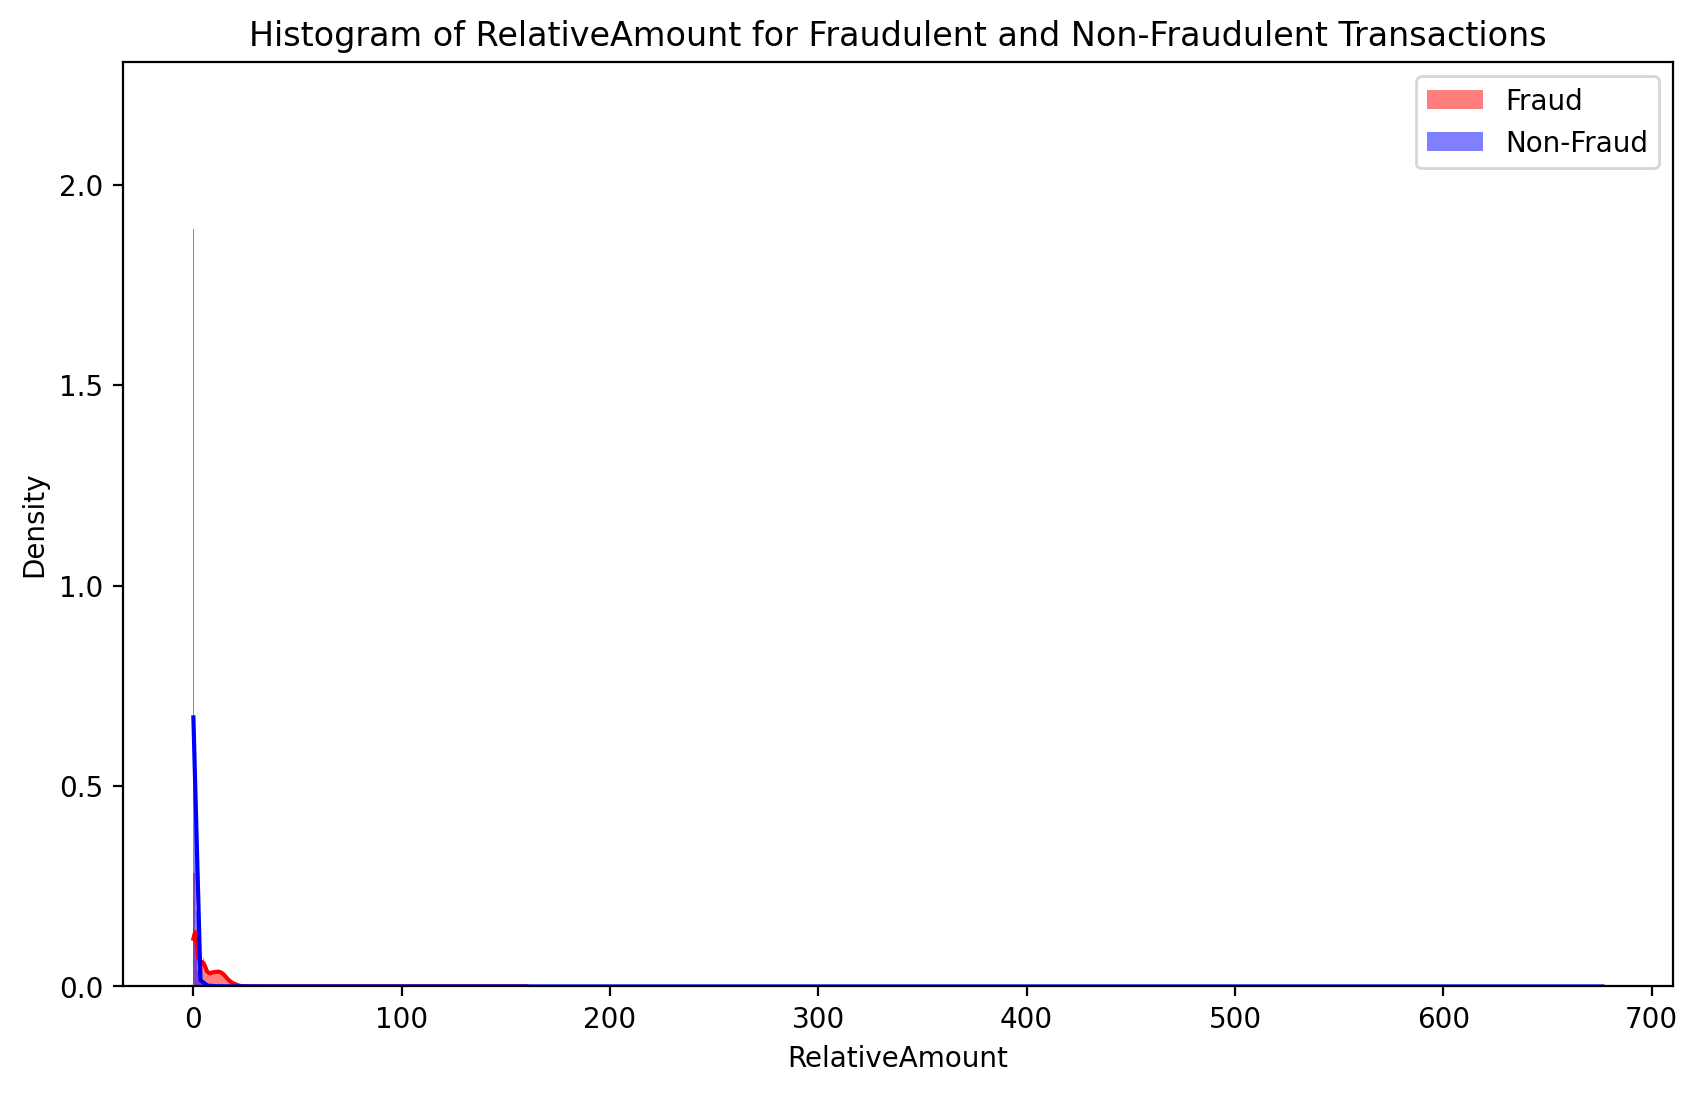

Feature: user_avg_amount, t-statistic: 28.235649036956396, p-value: 1.6646237935316114e-168


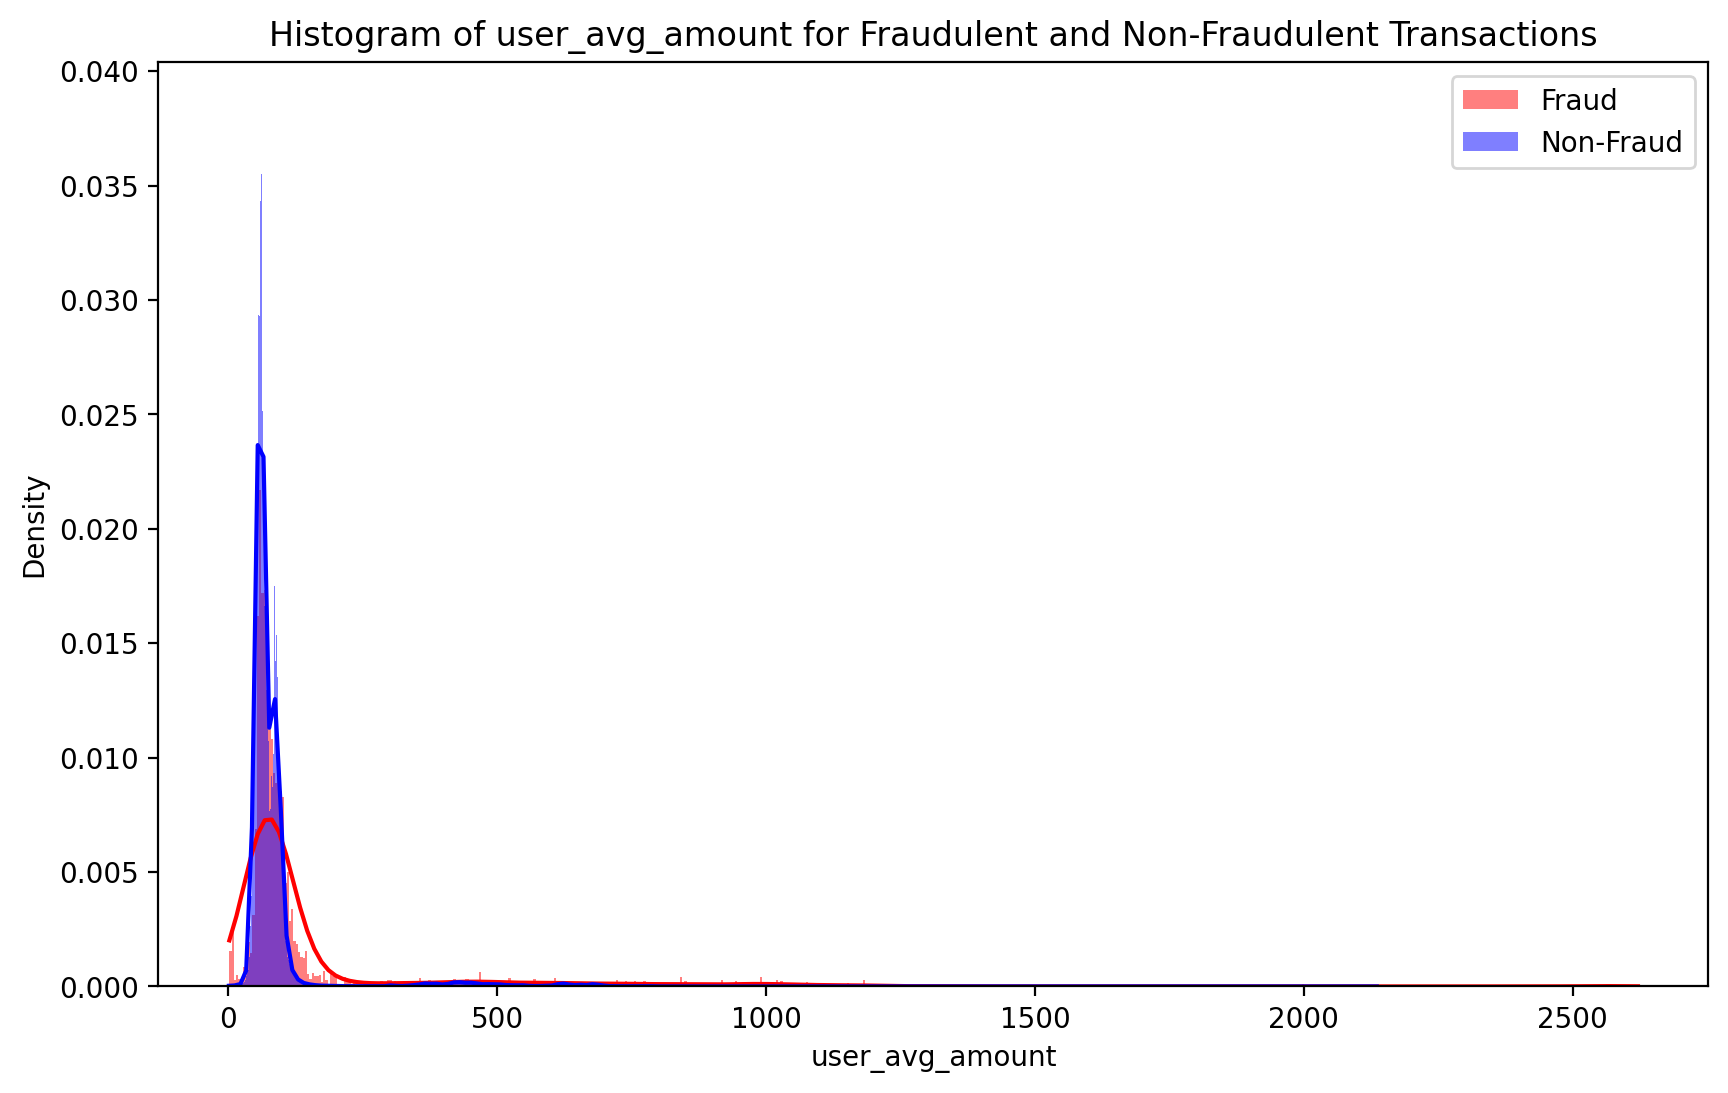

Feature: is_late_night, t-statistic: 95.21771018301571, p-value: 0.0


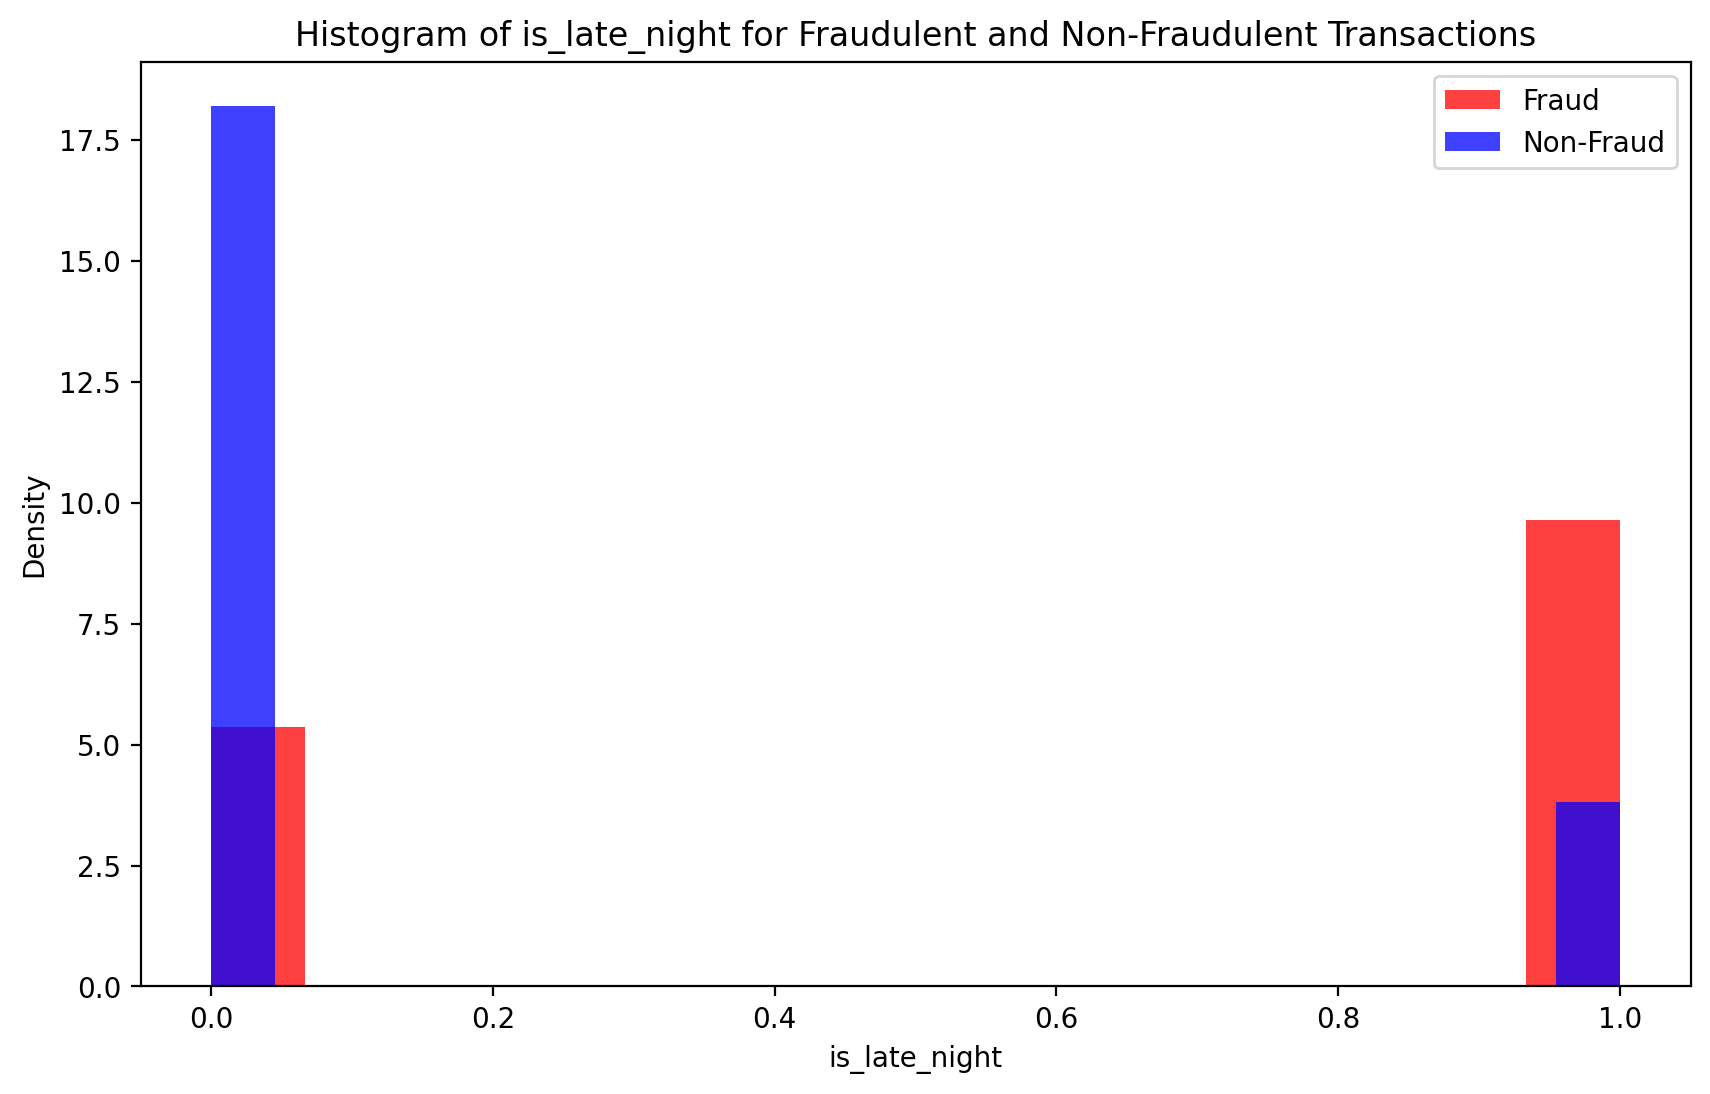

Feature: count_trend_1h, t-statistic: 44.6015016809369, p-value: 0.0


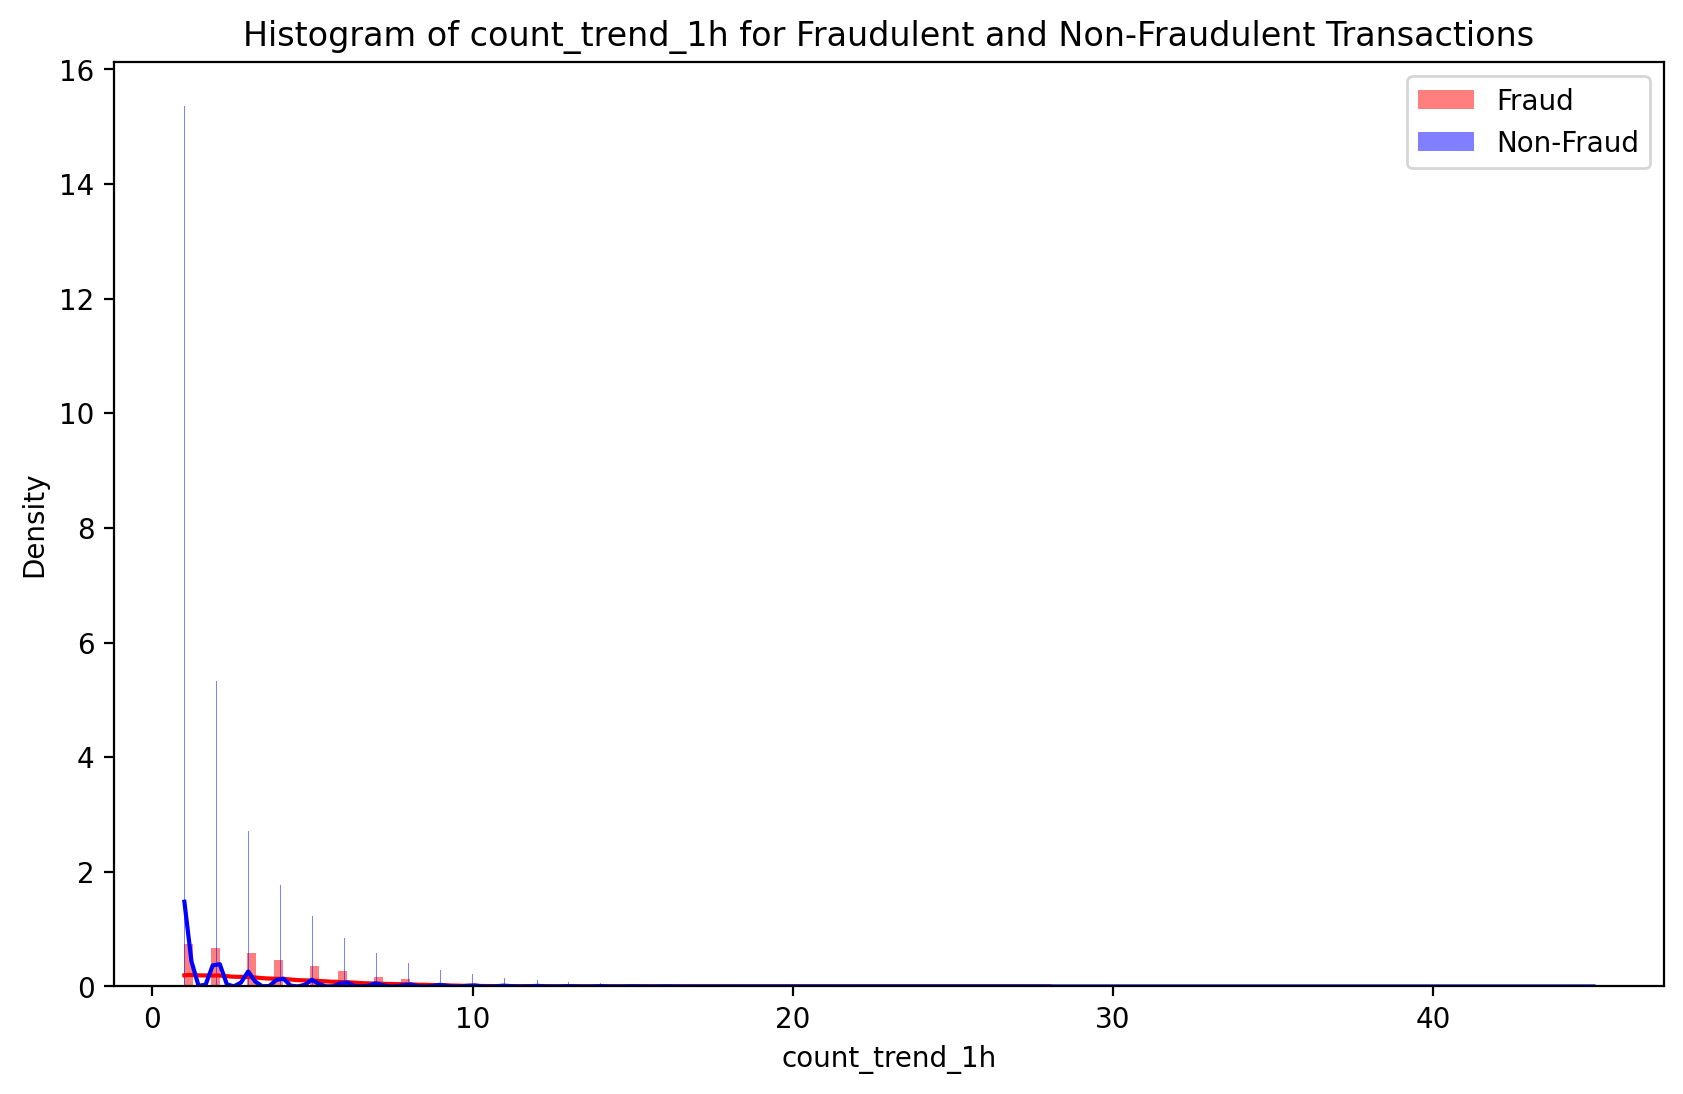

In [ ]:
# Generate descriptive statistics for fraud and non-fraud transactions
fraud = df[df['mdlIsFraudTrx'] == 1]
non_fraud = df[df['mdlIsFraudTrx'] == 0]

# Ensure df.columns is a list of strings
df_columns = list(map(str, df.columns))

# Features
if "datetime" in df.columns:
  features = list(set(df_columns) - set(base_cols + ["datetime"]))
else:
  features = list(set(df_columns) - set(base_cols))

for feature in features:
    # T-test
    t_stat, p_val = ttest_ind(fraud[feature].dropna(), non_fraud[feature].dropna(), equal_var=False)
    print(f'Feature: {feature}, t-statistic: {t_stat}, p-value: {p_val}')

    # Histogram
    if len(df[feature].unique()) > 2:
      kde = True
    else:
      kde = False
    plt.figure(figsize=(10, 6))
    sns.histplot(fraud[feature], color='red', label='Fraud', kde=kde, stat="density", linewidth=0)
    sns.histplot(non_fraud[feature], color='blue', label='Non-Fraud', kde=kde, stat="density", linewidth=0)
    plt.title(f'Histogram of {feature} for Fraudulent and Non-Fraudulent Transactions')
    plt.legend()
    plt.show()


# In addition to the time-based average and event-based average, we can create features such as:
- **Transaction Amount Difference:** Difference between the current and previous transaction amounts.
- **Transaction Frequency:** Number of transactions within a specific period.
- **Transaction Ratio:** Ratio of a specific type of transaction (e.g., online) to the total number of transactions.

- Try defining the above definitions and attaching columns to your dataframe in a similar way to the functions above

###Sometimes when we have a surplus of variables, or don't want the model to run for extended periods of time, we will curate our variable list to something more manageable given our resources. Later, we will use performance metrics and sensitivity to understand which variables are the best, but for now, we can look at which variables are highly correlated and may be redundant with each other

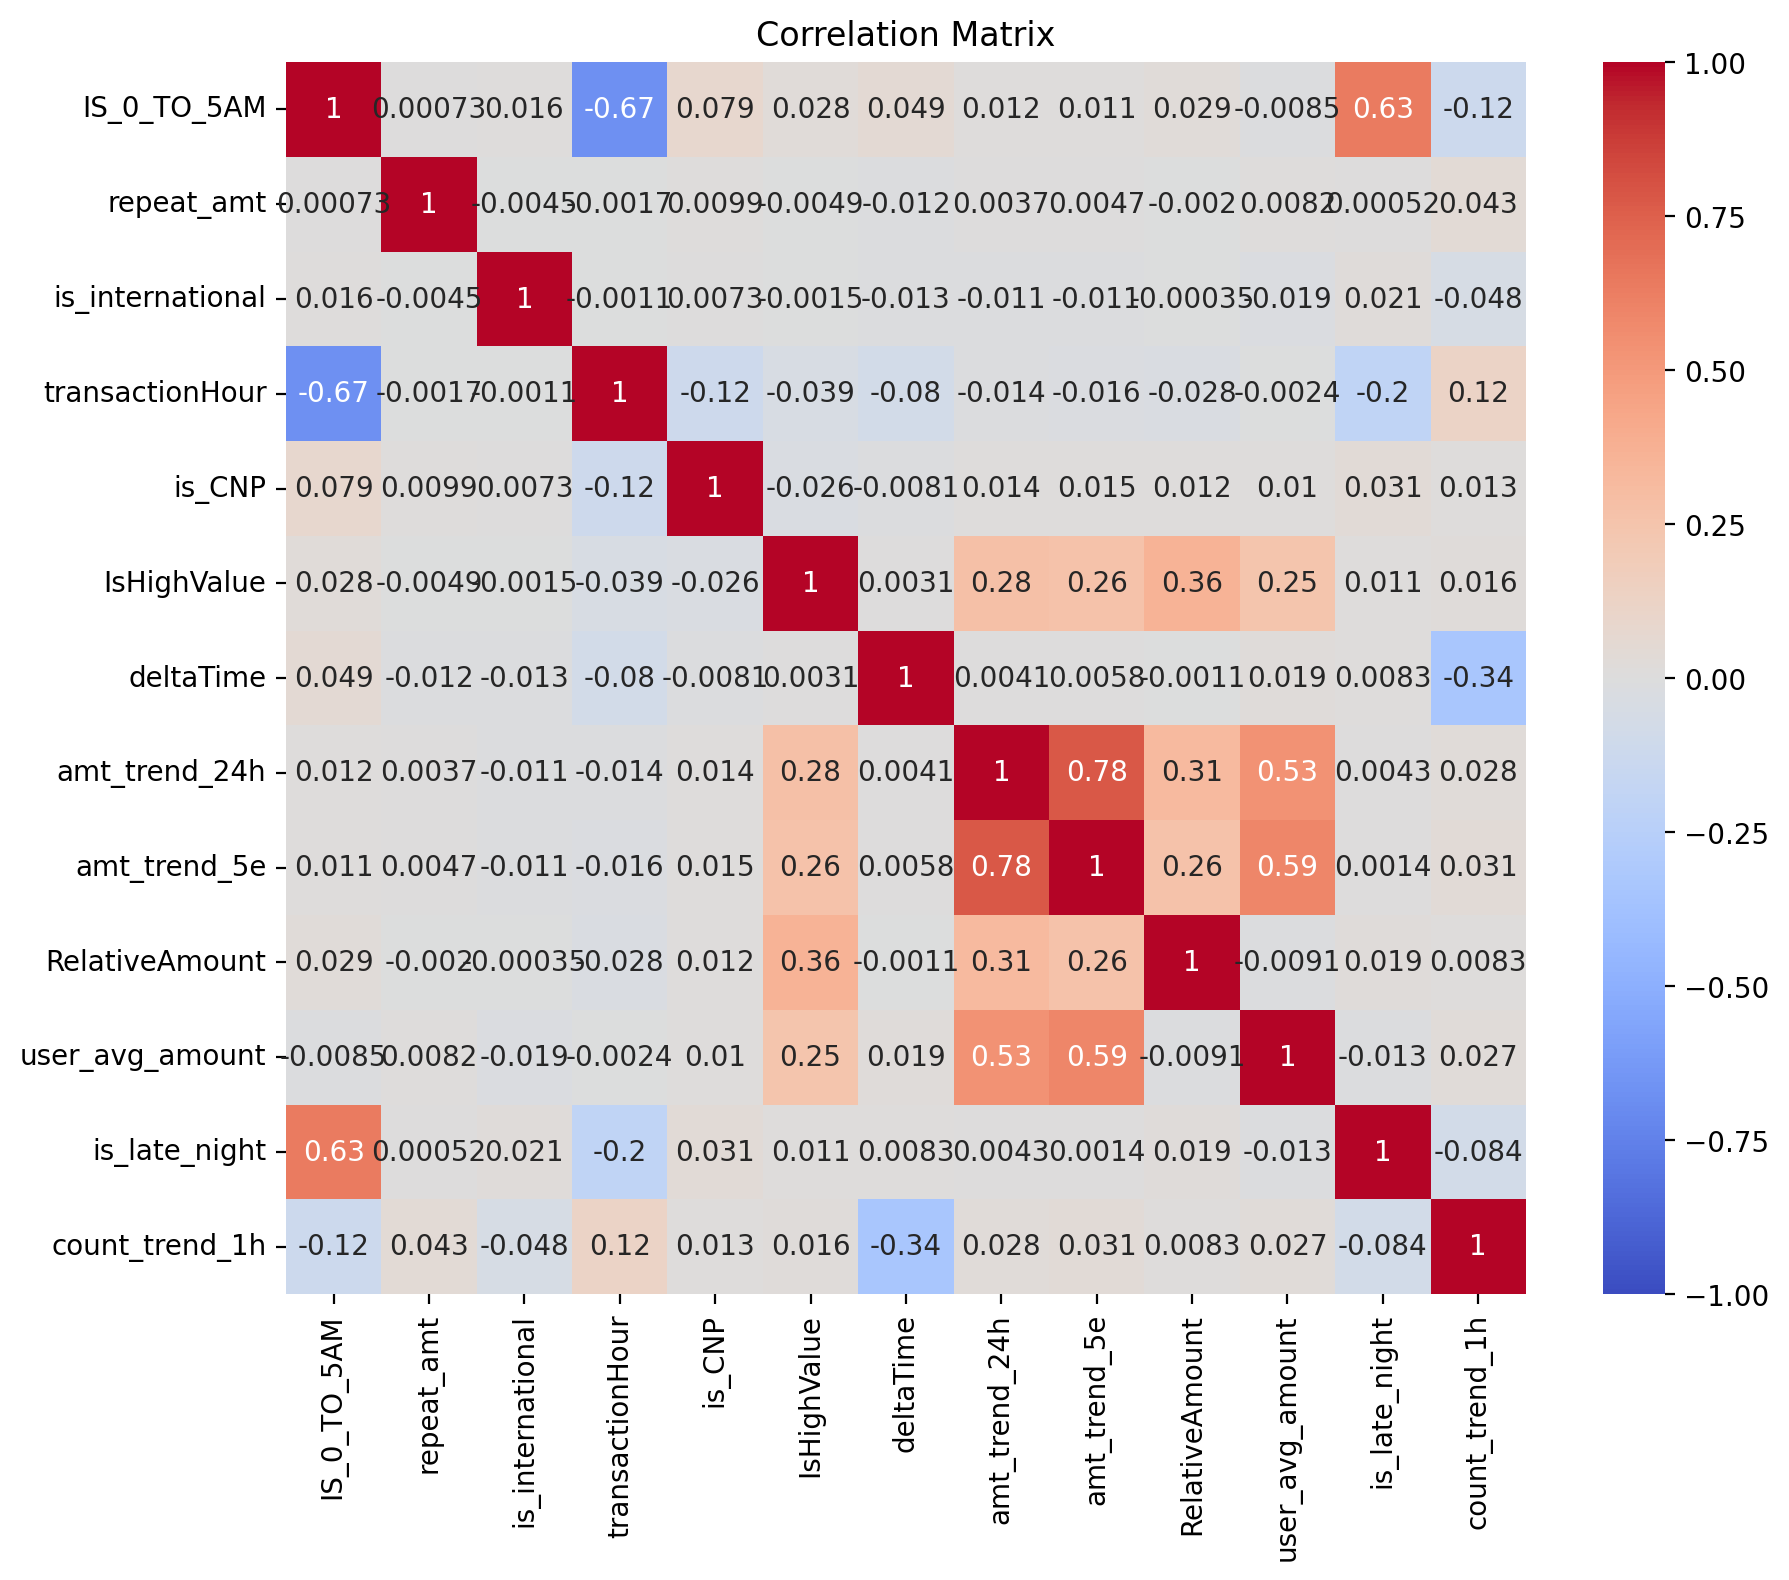

In [ ]:
JF = df[features]
correlation_matrix = JF.corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

This plot shows how correlated our features are with other features in our dataframe. Higher numbers mean higher correlation. The diagonal of our correlation matrix is filled with ones since a feature is exactly correlated with itself by definition. When some variables are too correlated with each other, we usually remove the less impactful feature. Here, you can see that our IS_0_TO_5AM and is_late_night variables are somewhat correlated.

## Now that we have a dataframe with some potentially useful features, let's save it to be used in future sessions.

## Exercise

In [ ]:
df['amount_diff'] = #TODO
df['num_last_24_hours'] = #TODO
df['num_hi_amt_last_hour'] = #TODO
df['category_ratio'] = #TODO

#Generate 3 other variables to be used in your neural net and logreg models

SyntaxError: invalid syntax (<ipython-input-36-4b3b7e075aa8>, line 1)

# Answers

In [ ]:
df['amount_diff'] = df.groupby('pan')['transactionAmount'].diff()

# Fill NaN values with 0 or any other value
df['amount_diff'] = df['amount_diff'].fillna(0.01)

In [ ]:
df.set_index('datetime', inplace=True)
df['num_last_24_hours'] = df.groupby('pan')['transactionAmount'].apply(lambda x: x.rolling(window='24h').count()).reset_index(level=0, drop=True)

In [ ]:
# Define the rolling window criteria function
def rolling_count_fill(x, hour='1h'):
    # Apply rolling window and count values > 100
    rolling_counts = x.rolling(hour, on='transactionDateTime')['transactionAmount'] \
        .apply(lambda y: (y > 100).sum(), raw=True)

    # Replace NaN: carry forward last valid count or use 0 if none
    filled_counts = rolling_counts.fillna(0).where(rolling_counts > 0, rolling_counts.ffill().fillna(0))
    return filled_counts

# Group by 'pan' and apply the rolling count with NaN handling
df['num_hi_amt_last_hour'] = df.groupby('pan', group_keys=False).apply(rolling_count_fill, '1h')

In [ ]:
def calculate_category_ratio(df):

    # Define a function to compute rolling category ratios for each customer
    def compute_ratios(group):
        # Create a boolean mask of matches within the past 5 records (rolling window)
        match_mask = (group['category'] == group['category'].shift(1))
        # Rolling sum of matches for past 5 rows
        rolling_sum = match_mask.rolling(window=5, min_periods=1).sum()
        # Calculate the ratio
        return rolling_sum / rolling_sum.rolling(window=5, min_periods=1).count()

    # Apply the function group-wise (for each customer)
    df['category_ratio'] = df.groupby('pan', group_keys=False).apply(compute_ratios)

    return df

df = calculate_category_ratio(df)

In [ ]:
nan_columns = df.columns[df.isna().any()]
print(f"Columns with NaN values: {nan_columns}")

for nanCol in nan_columns:
  num_nan = df[nanCol].isna().sum()
  print(f"The {nanCol} column contains {num_nan} NaN values.")

In [ ]:
df.isna().sum()

In [ ]:
def generateFeatures(csvFile, saveFile):
    # Upload pre-processed data
    df = import_df(csvFile)

    # Ensure base_cols is a list of strings
    base_cols = list(map(str, df.columns))

    # Since many of our features will be calculated at the account level, let's sort our features accordingly
    df = df.sort_values(by=['pan', 'transactionDateTime'])

    # It often helps to decompose the datetime into more useful fields
    df['datetime'] =  pd.to_datetime(df['transactionDateTime'])
    df['transactionHour'] = df['datetime'].dt.hour

    # Calculate binary variables

    # Fraudsters want to get as much money as fast as possible. Having a high value variable might catch some of the more greedy criminals
    df['IsHighValue'] = (df['transactionAmount'] > 100.).astype(int)

    # Transactions occurring in a country different from the customer's home country can indicate potential fraud, especially if the customer rarely travels.
    df['is_international'] = (df['merchCountry'] != df['cardholderCountry']).astype(int)

    # Fraud is most easily committed anonymously and discreetly; by conducting the crime over the internet, the chances of being caught are much lower.
    df['is_CNP'] =  (df['category'].apply(lambda x: x[-3:] == 'net')).astype(int)

    # Similarly, security and awareness are at their lowest at off hours. Fraudsters frequently exploit this weakness.
    df['IS_0_TO_5AM'] = (df['transactionHour'].astype(int) < 5).astype(int)

    # Let's try and be more in-line with the data as was seen in week 3:
    df['is_late_night'] = ((df['transactionHour'].astype(int) < 4) | (df['transactionHour'].astype(int) > 21)).astype(int)

    # PAN behavior anomalies

    #For this next line: the combination of expanding() and shift() take only the data prior to our current transaction
    df['user_avg_amount'] = df.groupby('pan', group_keys=False)['transactionAmount'].transform(lambda x: x.expanding().mean().shift())
    df['user_avg_amount'] = df['user_avg_amount'].fillna(df['transactionAmount'])
    # df['user_avg_amount'] = df['user_avg_amount'].fillna(0)

    # By comparing a user's current transaction to their normal spending activity, we may detect user-specific anomalies
    df['RelativeAmount'] = df['transactionAmount'] / df['user_avg_amount']
    # df['RelativeAmount'].replace([np.inf, -np.inf], 0, inplace=True)

    # Very short intervals between transactions can be suspicious, especially if they are unusual for the customer.
    df['deltaTime'] = df.groupby('pan')['datetime'].transform(lambda x: x.diff().dt.total_seconds()) #Time in seconds between the current and last transactions

    # Replace NaNs with 0
    df['deltaTime'] = df['deltaTime'].fillna(0)

    # This rolling average helps to understand the trend in transaction amounts. Sudden changes in trend might be indicative of fraud.
    df['amt_trend_5e'] = df.groupby('pan')['transactionAmount'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

    # Often times, fraudsters will purchase or withdraw the same item or amount in succession
    df['repeat_amt'] = (df['transactionAmount'] == df.groupby('pan')['transactionAmount'].shift(1)).astype(int)

    # Instead of taking the trend over a number of events, we can also specify a period over which we're interested
    df.set_index('datetime', inplace=True)

    # Looking at the average of the last day's transactions may reveal a large average transaction trend
    df['amt_trend_24h'] = df.groupby('pan')['transactionAmount'].transform(lambda x: x.rolling(window='24h').mean())

    # Looking at the number volume of transactions can often also be an indicator of
    # fraud. The perpetrators want to commit as muhc fraud as fast as possible
    df['count_trend_1h'] = df.groupby('pan')['transactionAmount'].transform(lambda x: x.rolling(window='1h').count())

    df.reset_index(drop=True, inplace=True)

    # ##########################################################################
    # ###################### STUDENTS Extra Features Start #####################
    # ##########################################################################

    if 'datetime' not in df.columns:
      df['datetime'] =  pd.to_datetime(df['transactionDateTime'])
      df = df.sort_values(by=['pan', 'transactionDateTime'])
      df.reset_index(drop=True, inplace=True)
    # =========================================================
    # ======= Features that DO NOT require 'datetime' as index
    # =========================================================

    # Transaction Amount Difference: Difference between the current and previous transaction amounts
    df['amount_diff'] = df.groupby('pan')['transactionAmount'].diff()
    # Fill NaN values with 0 or any other value
    df['amount_diff'] = df['amount_diff'].fillna(0.01)



    # =========================================================
    # =========== Features that DO require 'datetime' as index
    # =========================================================
    df.set_index('datetime', inplace=True)

    # Calculate the number of transactionAmount entries in the last 24 hours for each pan
    df['num_last_24_hours'] = df.groupby('pan')['transactionAmount'].apply(lambda x: x.rolling(window='24h').count()).reset_index(level=0, drop=True)

    # Define the rolling window criteria function
    def rolling_count_fill(x, hour='1h'):
        # Apply rolling window and count values > 100
        rolling_counts = x.rolling(hour, on='transactionDateTime')['transactionAmount'] \
            .apply(lambda y: (y > 100).sum(), raw=True)

        # Replace NaN: carry forward last valid count or use 0 if none
        filled_counts = rolling_counts.fillna(0).where(rolling_counts > 0, rolling_counts.ffill().fillna(0))
        return filled_counts

    # Group by 'pan' and apply the rolling count with NaN handling
    df['num_hi_amt_last_hour'] = df.groupby('pan', group_keys=False).apply(rolling_count_fill, '1h')

    def calculate_category_ratio(df):

        # Define a function to compute rolling category ratios for each customer
        def compute_ratios(group):
            # Create a boolean mask of matches within the past 5 records (rolling window)
            match_mask = (group['category'] == group['category'].shift(1))
            # Rolling sum of matches for past 5 rows
            rolling_sum = match_mask.rolling(window=5, min_periods=1).sum()
            # Calculate the ratio
            return rolling_sum / rolling_sum.rolling(window=5, min_periods=1).count()

        # Apply the function group-wise (for each customer)
        df['category_ratio'] = df.groupby('pan', group_keys=False).apply(compute_ratios)

        return df

    df = calculate_category_ratio(df)

    # ##########################################################################
    # ###################### STUDENTS Extra Features END #######################
    # ##########################################################################
    df.reset_index(drop=True, inplace=True)

    # Ensure df.columns is a list of strings
    df_columns = list(map(str, df.columns))

    # Features to save
    if "datetime" in df.columns:
      features = list(set(df_columns) - set(base_cols + ["datetime"]))
    else:
      features = list(set(df_columns) - set(base_cols))

    saveFeatures = [*base_cols, *features]
    print(f"Features to save: {saveFeatures}")

    df[saveFeatures].to_csv(saveFile,index=False)

    return df

In [ ]:
# Dataset file prefix
File = ['train']

# Set to "True" if importing base dataset; default is False
base=True

# Set to "True" if creating advanced features; default is False
creatingAdvancedFeatures=False

# Set to "True" if using advanced features, "False" if using regular features and not base; default is False
usingAdvancedFeatures=False

# CSV filename and where outputs will be saved
CSV, saveCSV, _ = featuresFileSuffix(data_path, File, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)

Only in Week 4
Using train.csv as input. Creating Features and saving all features to train_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/train.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/train_features.csv



In [ ]:
df_temp = generateFeatures(CSV, saveCSV)

Features to save: ['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last', 'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx', 'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry', 'merchState', 'cardholderCountry', 'cardholderState', 'IS_0_TO_5AM', 'repeat_amt', 'amount_diff', 'is_international', 'transactionHour', 'is_CNP', 'IsHighValue', 'deltaTime', 'amt_trend_24h', 'num_hi_amt_last_hour', 'amt_trend_5e', 'RelativeAmount', 'num_last_24_hours', 'user_avg_amount', 'is_late_night', 'count_trend_1h', 'category_ratio']


In [ ]:
# Dataset file prefix
File = ['test_A']

# Set to "True" if importing base dataset; default is False
base=True

# Set to "True" if creating advanced features; default is False
creatingAdvancedFeatures=False

# Set to "True" if using advanced features, "False" if using regular features and not base; default is False
usingAdvancedFeatures=False

# CSV filename and where outputs will be saved
CSV, saveCSV, _ = featuresFileSuffix(data_path, File, creatingAdvancedFeatures, usingAdvancedFeatures, base=base)

Only in Week 4
Using test_A.csv as input. Creating Features and saving all features to test_A_features.csv
File 1: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_A.csv
File 2: /content/drive/MyDrive/FICO Analytic Challenge/Data/test_A_features.csv



In [ ]:
df_tempA = generateFeatures(CSV, saveCSV)

Features to save: ['pan', 'merchant', 'category', 'transactionAmount', 'first', 'last', 'gender', 'street', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'mdlIsFraudTrx', 'mdlIsFraudAcct', 'transactionDateTime', 'is_train', 'merchCountry', 'merchState', 'cardholderCountry', 'cardholderState', 'IS_0_TO_5AM', 'repeat_amt', 'amount_diff', 'is_international', 'transactionHour', 'is_CNP', 'IsHighValue', 'deltaTime', 'amt_trend_24h', 'num_hi_amt_last_hour', 'amt_trend_5e', 'RelativeAmount', 'num_last_24_hours', 'user_avg_amount', 'is_late_night', 'count_trend_1h', 'category_ratio']
